In [1]:
!pip install optuna plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 17.2 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.amp import GradScaler, autocast
import math
import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import time
import optuna
from optuna.pruners import MedianPruner
import plotly
import random

from google.colab import drive
drive.mount('/content/drive')

# Set path to dataset zip and extract to get data
zip_path = "/content/drive/MyDrive/archive.zip"
import zipfile
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("data")

dataset_folder = "data/random_split"

Mounted at /content/drive


## Read in data

In [3]:
# Read in data and filter for sequence, aligned_sequence, family_accession columns
def read_and_filter(folder):
    dfs = []
    path = os.path.join(dataset_folder, folder)
    for filename in os.listdir(path):
        file_path = os.path.join(path, filename)
        df = pd.read_csv(file_path, usecols=["sequence","aligned_sequence", "family_accession"])
        dfs.append(df)
    return pd.concat(dfs).reset_index(drop=True)

# read in datasets
train_df = read_and_filter("train")
dev_df = read_and_filter("dev")
test_df = read_and_filter("test")

# print structure of datasets
print("Train:", train_df.shape)
print("Dev:", dev_df.shape)
print("Test:", test_df.shape)
print()

# count unique families
train_families = set(train_df["family_accession"].unique())
dev_families = set(dev_df["family_accession"].unique())
test_families = set(test_df["family_accession"].unique())
print("Unique families:")
print(f"Train: {len(train_families)}")
print(f"Dev:   {len(dev_families)}")
print(f"Test:  {len(test_families)}")
print()

# check overlap of families across the 3 df
print("Overlap:")
print(f"all Dev in Train?  {dev_families.issubset(train_families)}")
print(f"all Test in Train?  {test_families.issubset(train_families)}")
print(f"all Test in Dev?  {test_families.issubset(dev_families)}")
print()

# check sequence length stats for attention
print("Sequence length stats:")
train_lengths = train_df["sequence"].str.len()
print(f"Train > Min: {train_lengths.min()}, Max: {train_lengths.max()}")
dev_lengths = dev_df["sequence"].str.len()
print(f"Dev > Min: {dev_lengths.min()}, Max: {dev_lengths.max()}")
test_lengths = test_df["sequence"].str.len()
print(f"Test > Min: {test_lengths.min()}, Max: {test_lengths.max()}")

Train: (1086741, 3)
Dev: (126171, 3)
Test: (126171, 3)

Unique families:
Train: 17929
Dev:   13071
Test:  13071

Overlap:
all Dev in Train?  True
all Test in Train?  True
all Test in Dev?  True

Sequence length stats:
Train > Min: 4, Max: 2037
Dev > Min: 9, Max: 1971
Test > Min: 9, Max: 1937


In [4]:
# Filter train_df to keep only families that are in test set
train_families = set(train_df["family_accession"].unique())
test_families = set(test_df["family_accession"].unique())
training_trunc = train_df[train_df["family_accession"].isin(test_families)]

# Verify the new dataset
print("training_trunc:", training_trunc.shape)
print(f"Unique families in training_trunc: {len(set(training_trunc['family_accession'].unique()))}")


training_trunc: (1064950, 3)
Unique families in training_trunc: 13071


## To get a better idea of the distribution of the data we visualise the following:  Distribution of sequence length, Distribution of family size

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot distribution of full sequence lengths
sns.histplot(training_trunc["sequence"].str.len(), label="Training_trunc", color="blue", alpha=0.5, bins=50, ax=ax1)
sns.histplot(test_df["sequence"].str.len(), label="Test", color="orange", alpha=0.5, bins=50, ax=ax1)
ax1.set_title("Distribution of Full Sequence Lengths")
ax1.set_xlabel("Sequence Length (amino acids)")
ax1.set_ylabel("Count")
ax1.legend()

# Plot distribution of aligned sequence lengths
sns.histplot(training_trunc["aligned_sequence"].str.len(), label="Training_trunc", color="blue", alpha=0.5, bins=50, ax=ax2)
sns.histplot(test_df["aligned_sequence"].str.len(), label="Test", color="orange", alpha=0.5, bins=50, ax=ax2)
ax2.set_title("Distribution of Aligned Sequence Lengths")
ax2.set_xlabel("Sequence Length (amino acids)")
ax2.set_ylabel("Count")
ax2.legend()

plt.tight_layout()
plt.show()

# Print stats for distribution of sequence length
print("Raw training sequence length stats")
lengths = training_trunc["sequence"].str.len()
percentiles = [50, 75, 90, 95, 99]
for p in percentiles:
    value = np.percentile(lengths, p)
    print(f"{p}th percentile: {value}")
print()

print("Raw test sequence length stats")
lengths = test_df["sequence"].str.len()
percentiles = [50, 75, 90, 95, 99]
for p in percentiles:
    value = np.percentile(lengths, p)
    print(f"{p}th percentile: {value}")
print()

print("Aligned training sequence length stats")
lengths = training_trunc["aligned_sequence"].str.len()
percentiles = [50, 75, 90, 95, 99]
for p in percentiles:
    value = np.percentile(lengths, p)
    print(f"{p}th percentile: {value}")


: 

In [ ]:
# CDF plots for percentage explained vs sequence length
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Function to plot the CDF
def plot_cdf(ax, lengths, label, color):
    sorted_lengths = np.sort(lengths)
    cumulative_percent = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths) * 100
    ax.plot(sorted_lengths, cumulative_percent, label=label, color=color)

# Full sequences subplot
plot_cdf(ax1, training_trunc["sequence"].str.len(), "Training_trunc", "blue")
plot_cdf(ax1, test_df["sequence"].str.len(), "Test", "orange")
ax1.axvline(x=383, color="red", linestyle="--", label="Length=383")
ax1.set_title("Full Sequence Lengths")
ax1.set_xlabel("Sequence Length (amino acids)")
ax1.set_ylabel("Cumulative Percentage (%)")
ax1.legend()
ax1.grid(True)

# Aligned sequences subplot
plot_cdf(ax2, training_trunc["aligned_sequence"].str.len(), "Training_trunc", "blue")
plot_cdf(ax2, test_df["aligned_sequence"].str.len(), "Test", "orange")
ax2.axvline(x=383, color="red", linestyle="--", label="Length=383")
ax2.set_title("Aligned Sequence Lengths")
ax2.set_xlabel("Sequence Length (amino acids)")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


The plots above show that only 5% of the sequences are longer than 383.  Therefore we will truncate at 383 because the gain in information is not worth the complexity increase from extending context length.  Also 383 + 1 (CLS) = 384 this is divisible by 32 and 16 to align with GPU warp sizes

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 1]})

# CDF Plot (Left)
def plot_family_cdf(ax, df, label, color):
    # Count sequences per family, sort by count (descending)
    family_counts = df['family_accession'].value_counts().sort_values(ascending=False)
    # Cumulative sum and percentage
    cumulative_sum = family_counts.cumsum()
    cumulative_percent = cumulative_sum / cumulative_sum.iloc[-1] * 100
    # Plot CDF
    ax.plot(range(1, len(family_counts) + 1), cumulative_percent, label=label, color=color, linewidth=2)

# Plot CDF for both datasets
plot_family_cdf(ax1, training_trunc, "Training_trunc", "blue")
plot_family_cdf(ax1, test_df, "Test", "orange")
ax1.set_title("Family Sequence Distribution (CDF)", fontsize=14)
ax1.set_xlabel("Family Rank (by sequence count)", fontsize=12)
ax1.set_ylabel("Cumulative Percentage of Sequences (%)", fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, linestyle='--', alpha=0.7)
# Set x-axis limit to include all families
max_families = max(len(training_trunc['family_accession'].unique()), len(test_df['family_accession'].unique()))
ax1.set_xlim(0, max_families)
ax1.set_ylim(0, 100)

# Distribution Plot (Right)
def plot_family_distribution(ax, df, label, color):
    # Count sequences per family, sort by count (descending)
    family_counts = df['family_accession'].value_counts().sort_values(ascending=False)
    # Plot number of sequences vs. family rank (representing number of families)
    ax.plot(range(1, len(family_counts) + 1), family_counts.values, label=label, color=color, linewidth=2)

# Plot distribution for both datasets
plot_family_distribution(ax2, training_trunc, "Training_trunc", "blue")
plot_family_distribution(ax2, test_df, "Test", "orange")
ax2.set_title("Number of Sequences per Family", fontsize=14)
ax2.set_xlabel("Family Rank (Number of Families)", fontsize=12)
ax2.set_ylabel("Number of Sequences", fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, linestyle='--', alpha=0.7)
# Log scale for y-axis to handle wide range of sequence counts
ax2.set_yscale('log')
ax2.set_xlim(0, max_families)
max_sequences = max(training_trunc['family_accession'].value_counts().max(),
                   test_df['family_accession'].value_counts().max())
ax2.set_ylim(1, max_sequences * 1.1)

plt.tight_layout()
plt.show()

def print_family_distribution_metrics(df, dataset_name):
    print(f"\nMetrics for {dataset_name}:")

    # Count sequences per family
    family_counts = df['family_accession'].value_counts()
    total_sequences = family_counts.sum()
    total_families = len(family_counts)

    # Basic stats
    print(f"Total sequences: {total_sequences}")
    print(f"Total unique families: {total_families}")
    print(f"Max sequences per family: {family_counts.max()}")
    print(f"Min sequences per family: {family_counts.min()}")
    print(f"Mean sequences per family: {family_counts.mean():.2f}")
    print(f"Median sequences per family: {family_counts.median():.2f}")

    # Sort counts for cumulative analysis
    sorted_counts = family_counts.sort_values(ascending=False)
    cumulative_sum = sorted_counts.cumsum()
    cumulative_percent = cumulative_sum / total_sequences * 100

    # Percentage of sequences covered by top N families
    for n in [10, 50, 100, 500, 1000]:
        if n <= total_families:
            percent = cumulative_percent.iloc[n-1]
            print(f"Top {n} families cover {percent:.2f}% of sequences ({cumulative_sum.iloc[n-1]} sequences)")

    # Number of families needed for cumulative percentages (50%, 80%, 90%, 95%)
    for target_percent in [50, 80, 90, 95]:
        families_needed = np.argmax(cumulative_percent >= target_percent) + 1
        sequences_covered = cumulative_sum.iloc[families_needed-1]
        print(f"{target_percent}% of sequences covered by top {families_needed} families ({sequences_covered} sequences)")

# For both datasets
print_family_distribution_metrics(training_trunc, "Training_trunc")
print_family_distribution_metrics(test_df, "Test")

## Truncating the data
With the computational resources available, it is not feasible to train and optimise a comprehensive model on the full dataset of 1 million sequences and 13071 families.  I truncated the data set to 100 families, chosen randomly but based on how many members each family has.  This keeps the distribution of big and small families similar to the full dataset. With this we can assess the model’s performance on families of different sizes where some have more than 1000 data points and some have less than 10.

In [8]:
# Function to truncate data set according to distribution of full dataset
def truncate_to_n_families(training_df, test_df, n=100, seed=42):
    rng = np.random.RandomState(seed)

    # Calculate frequency of each family in training data
    family_counts = training_df['family_accession'].value_counts()
    unique_families = family_counts.index.tolist()

    # Calculate selection probabilities proportional to frequency
    probabilities = family_counts / family_counts.sum()

    # Sample n families without replacement based on distribution
    selected_families = rng.choice(unique_families, size=n, replace=False, p=probabilities)

    # Filter datasets for selected families only
    truncated_training_df = training_df[training_df['family_accession'].isin(selected_families)]
    truncated_test_df = test_df[test_df['family_accession'].isin(selected_families)]

    print(f"\nTruncation Results:")
    print(f"Selected {n} families mimicking training distribution")
    print(f"Truncated training_df: {len(truncated_training_df)} sequences, {len(truncated_training_df['family_accession'].unique())} families")
    print(f"Truncated test_df: {len(truncated_test_df)} sequences, {len(truncated_test_df['family_accession'].unique())} families")

    return truncated_training_df, truncated_test_df

truncated_training_trunc, truncated_test_df = truncate_to_n_families(training_trunc, test_df, 100, seed=42)


Truncation Results:
Selected 100 families mimicking training distribution
Truncated training_df: 31717 sequences, 100 families
Truncated test_df: 3913 sequences, 100 families


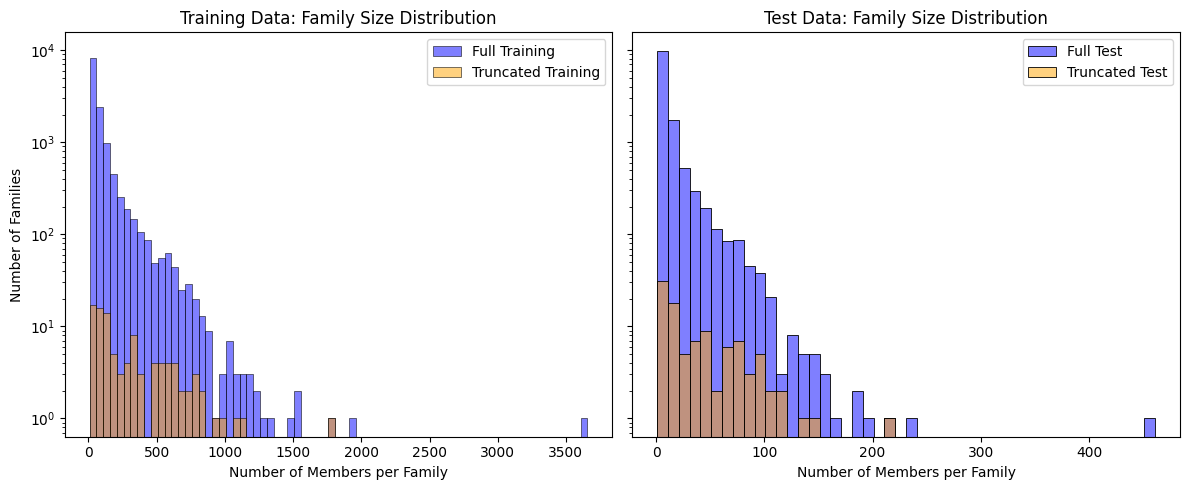

In [9]:
# Plot the distribution of family size of full vs truncated data
# Function to calculate family sizes
def get_family_sizes(df):
    return df['family_accession'].value_counts()

# Calculate family sizes for each dataset
train_full_sizes = get_family_sizes(training_trunc)
train_trunc_sizes = get_family_sizes(truncated_training_trunc)
test_full_sizes = get_family_sizes(test_df)
test_trunc_sizes = get_family_sizes(truncated_test_df)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
# Training data
bin_width = 50
min_size_train = train_full_sizes.min()
max_size_train = train_full_sizes.max()
bin_edges_train = np.arange(min_size_train, max_size_train + bin_width, bin_width)
sns.histplot(train_full_sizes, label="Full Training", color="blue", alpha=0.5, bins=bin_edges_train, ax=ax1)
sns.histplot(train_trunc_sizes, label="Truncated Training", color="orange", alpha=0.5, bins=bin_edges_train, ax=ax1)
ax1.set_title("Training Data: Family Size Distribution")
ax1.set_xlabel("Number of Members per Family")
ax1.set_ylabel("Number of Families")
ax1.set_yscale('log')
ax1.legend()
# Test data
bin_width = 10
min_size_test = test_full_sizes.min()
max_size_test = test_full_sizes.max()
bin_edges_test = np.arange(min_size_test, max_size_test + bin_width, bin_width)
sns.histplot(test_full_sizes, label="Full Test", color="blue", alpha=0.5, bins=bin_edges_test, ax=ax2)
sns.histplot(test_trunc_sizes, label="Truncated Test", color="orange", alpha=0.5, bins=bin_edges_test, ax=ax2)
ax2.set_title("Test Data: Family Size Distribution")
ax2.set_xlabel("Number of Members per Family")
ax2.set_ylabel("Number of Families")
ax2.set_yscale('log')
ax2.legend()

plt.tight_layout()
plt.show()


##  Create tokenisation dictionary for amino acids & Pfam

In [10]:
# Get unique characters for vocabulary
def get_unique_chars(df, column):
    all_sequences = ''.join(df[column].astype(str).tolist())
    unique_chars = set(all_sequences)
    return unique_chars

train_unique_raw = get_unique_chars(truncated_training_trunc, 'sequence')
test_unique_raw = get_unique_chars(truncated_test_df, 'sequence')
print("Unique characters in raw sequences:")
print(f"Train: {sorted(train_unique_raw)}, Total:{len(train_unique_raw)}")
print(f"Test:  {sorted(test_unique_raw)}, Total: {len(test_unique_raw)}")

train_unique_aligned = get_unique_chars(truncated_training_trunc, 'aligned_sequence')
test_unique_aligned = get_unique_chars(truncated_test_df, 'aligned_sequence')
print("\nUnique characters in aligned sequences:")
print(f"Train: {sorted(train_unique_aligned)}, Total:{len(train_unique_aligned)}")
print(f"Test:  {sorted(test_unique_aligned)}, Total: {len(test_unique_aligned)}")

# Define vocabulary dictionary                CLS for classification token
special_tokens = ['[PAD]', '[CLS]', '[GAP]'] #PAD for sequence shorter than context size, GAP incase we use aligned sequences
amino_acid_tokens = sorted(train_unique_raw)
vocab = special_tokens + amino_acid_tokens
token_to_id = {token: idx for idx, token in enumerate(vocab)}
id_to_token = {idx: token for token, idx in token_to_id.items()}

# Define family mappings dictionary
train_families = set(truncated_training_trunc["family_accession"].unique())
num_classes = len(train_families)
print(f"Number of classes: {num_classes}")
family_to_id = {family: idx for idx, family in enumerate(sorted(train_families))}
id_to_family = {idx: family for family, idx in family_to_id.items()}

Unique characters in raw sequences:
Train: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'X', 'Y'], Total:22
Test:  ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'], Total: 20

Unique characters in aligned sequences:
Train: ['.', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'X', 'Y'], Total:23
Test:  ['.', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'], Total: 21
Number of classes: 100


## Model choice and Architecture
I considered 3 architectures: Convolutional Neural Networks (CNNs), BERT-style transformers, and BigBird transformers.

**1)** CNNS are effective at detecting local patterns, such as short motifs in protein sequences, using convolutional filters processing adjacent windows of amino acids. This makes them computationally efficient and robust for tasks like motif detection. However, their reliance on proximal convolution masks limits their ability to capture long-range dependencies which is important for protein family classification. Stacking multiple CNN layers can expand the receptive field, but this can dilute information.  When scaling up the model, the performance may plateau if the task involves long range dependencies like in our case.

**2)** BERT-style transformer’s self-attention is able to capture short, intermediate and long range dependencies essential for distinguishing protein families. Their downside is quadratic complexity (O(N²)) with sequence length, which is resource intensive as we increase context size.  

**3)** BigBird transformers address this with sparse attention—combining local, global, and random attention—for linear complexity (O(N)), enabling efficient handling of very long sequences. However, our dataset is positively skewed, with 95% of sequences under 384 tokens, so BigBird’s extended context benefits only a small fraction of the data. Additionally, its complex attention indexing and scatter operations is demanding on the limited available computational resources. I tested this model - the sparse attention operations and indexing took over 55% of CUDA time whereas this process would likely take less than 10% with FlashAttention for the BERT-style transformer case.  

**Final choice** - BERT-style transformer with a 384-token context size (383 Amino acid + 1 [CLS]), covering 95% of sequences fully, with the remaining 5% truncated. This balances the need to model long-range dependencies with computational efficiency, making it well-suited for protein family classification where global sequence features are essential


## Full sequence vs Aligned sequence
In the Pfam dataset, the full sequence is the raw amino acid sequence of a protein, while the aligned sequence is derived by aligning the raw sequence to a family-specific profile hidden Markov model (HMM). These aligned sequences include gaps, marked by ‘.’, which represent positions where the sequence lacks residues compared to the family’s conserved domain structure due to insertions or deletions. Gaps highlight structural or functional variations, making family-specific patterns much more explicit. Although aligned sequences are longer due to gaps, potentially challenging the 384-token context size, they simplify classification by explicitely pointing out distinguishing features of a family to the model. I trained one BERT model on full sequences and another on aligned sequences; the aligned model slightly outperformed, likely because gaps and pre-aligned patterns reduced ambiguity in family-specific traits. However, in applications where the protein’s family is unknown, aligned sequences aren’t available since alignment requires prior family identification. Thus, a model must rely on raw sequences. To explore this, I trained two models: one pre-trained on aligned sequences then fine-tuned on raw sequences(50 / 50 epoch split), and another trained solely on raw sequences. Both were trained for the same total number of epochs and tested on raw sequences. The raw-sequence-only model performed better, possibly because it learned directly from raw data without relying on alignment artifacts - models pretrained on aligned sequence would be heavily reliant on [GAP] tokens which is absent in raw sequences. Therefore, I chose a BERT-style model trained on raw sequences to explore further.  This being said, the tokenisation framework in my code is compatible with both raw sequence and aligned sequence training

## Architecture
**1) Self attention with CLS - multiheaded attention with RoPE**. Rotary Positional Embeddings (RoPE) was chosen to enhance the model’s ability to handle variable length protein sequences.  CLS token added at 0th position to aggregate the information of the entire sequence, this will be used for classification

**2) Loss function  - Focal loss, Label smoothing, Class weights** -  as seen on plots of the Pfam dataset, the data is highly imbalance - 50% of the data is from the biggest 1500 of 13071 families.  Hence the data is dominated by only a few families.  Focal loss to reduce overfitting to dominant families.  Label smoothing to help generalisation especially for ambiguous family assignment.  Class weights to boost the contribution of rare classes to the loss.  The aim is for these techniques to help in optimising performance on an imbalance dataset like ours

**3) Learning rate - linear warmup with cosine annealing** - linear warm up to stabilise early training and cosine annealing to aid robust convergence


In [ ]:
# Rotary Position Embeddings (RoPE) Function
def apply_rotary_embeddings(x, positions, head_dim):
    theta = 10000 ** (-2 * (torch.arange(0, head_dim, 2, device=x.device) / head_dim))
    angles = positions[:, :, None] * theta[None, None, :]
    sin = torch.sin(angles)
    cos = torch.cos(angles)
    x_reshaped = x.view(*x.shape[:-1], head_dim // 2, 2)
    x1, x2 = x_reshaped[..., 0], x_reshaped[..., 1]
    rotated_x = torch.stack((-x2, x1), dim=-1)
    x_rope = (x_reshaped * cos[:, None, :, :, None] + rotated_x * sin[:, None, :, :, None])
    return x_rope.view_as(x)

# Tokenization Function
def tokenize_sequence(sequence, is_aligned=False, max_sequence_tokens=383):
    tokens = ['[CLS]']
    for char in sequence[:max_sequence_tokens]:
        if is_aligned and char == '.':
            tokens.append('[GAP]')
        elif char in amino_acid_tokens:
            tokens.append(char)
        else:
            raise ValueError(f"Invalid character {char} in sequence")
    mask = [1] * len(tokens)
    total_length = max_sequence_tokens + 1
    while len(tokens) < total_length:
        tokens.append('[PAD]')
        mask.append(0)
    token_ids = [token_to_id[token] for token in tokens]
    return token_ids, mask

# Dataset Class
class PfamDataset(Dataset):
    def __init__(self, df, is_aligned=False, max_sequence_tokens=383):
        self.sequences = df['sequence' if not is_aligned else 'aligned_sequence'].tolist()
        self.labels = df['family_accession'].map(family_to_id).tolist()
        self.is_aligned = is_aligned
        self.max_sequence_tokens = max_sequence_tokens

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        tokens, mask = tokenize_sequence(sequence, self.is_aligned, self.max_sequence_tokens)
        return {'tokens': tokens, 'mask': mask, 'label': label}

# Collate Function
def collate_fn(batch):
    tokens = [item['tokens'] for item in batch]
    masks = [item['mask'] for item in batch]
    labels = [item['label'] for item in batch]
    tokens_tensor = torch.tensor(tokens, dtype=torch.long)
    masks_tensor = torch.tensor(masks, dtype=torch.long)
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    return {'tokens': tokens_tensor, 'masks': masks_tensor, 'labels': labels_tensor}

# Multihead Attention with RoPE
class MultiheadAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embedding_dim // num_heads
        self.q_proj = nn.Linear(embedding_dim, embedding_dim)
        self.k_proj = nn.Linear(embedding_dim, embedding_dim)
        self.v_proj = nn.Linear(embedding_dim, embedding_dim)
        self.out_proj = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, x, masks):
        batch_size, seq_len, embedding_dim = x.size()
        positions = torch.arange(0, seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        Q = self.q_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        K = self.k_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        V = self.v_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        Q_rope = apply_rotary_embeddings(Q, positions, self.head_dim)
        K_rope = apply_rotary_embeddings(K, positions, self.head_dim)
        attn_mask = masks.unsqueeze(1).unsqueeze(2).bool()
        attn_output = F.scaled_dot_product_attention(Q_rope, K_rope, V, attn_mask=attn_mask, is_causal=False)
        attn_output = attn_output.permute(0, 2, 1, 3).contiguous().view(batch_size, seq_len, embedding_dim)
        return self.out_proj(attn_output)

# Transformer Block
class Block(nn.Module):
    def __init__(self, embedding_dim, num_heads, hidden_dim, dropout):
        super().__init__()
        self.norm1 = nn.LayerNorm(embedding_dim)
        self.norm2 = nn.LayerNorm(embedding_dim)
        self.attention = MultiheadAttention(embedding_dim, num_heads)
        self.ff = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, embedding_dim),
            nn.Dropout(dropout)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, masks):
        attn_output = self.attention(self.norm1(x), masks)
        x = x + self.dropout(attn_output)
        ff_output = self.ff(self.norm2(x))
        return x + ff_output

# Model
class BERTModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_layers, num_heads, hidden_dim, num_classes, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.layers = nn.ModuleList([Block(embedding_dim, num_heads, hidden_dim, dropout) for _ in range(num_layers)])
        self.output_layer = nn.Linear(embedding_dim, num_classes)

    def forward(self, tokens, masks):
        embedded = self.embedding(tokens)
        for layer in self.layers:
            embedded = layer(embedded, masks)
        cls_output = embedded[:, 0, :]
        return self.output_layer(cls_output)

In [ ]:
# Learning Rate scheduler
def get_lr(it, max_lr, min_lr, warmup_steps, max_steps):
    if it < warmup_steps:
        return max_lr * (it + 1) / warmup_steps
    if it > max_steps:
        return min_lr
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (max_lr - min_lr)

# Loss Function with focal loss, label smoothing and weight scaling
class FocalLossWithLabelSmoothing(nn.Module):
    def __init__(self, num_classes, weights, gamma=2.0, epsilon=0.1):
        super().__init__()
        self.num_classes = num_classes
        self.weights = weights
        self.gamma = gamma
        self.epsilon = epsilon

    def forward(self, logits, labels):
        log_p = F.log_softmax(logits, dim=-1)  # Log-probabilities for loss computation
        p = F.softmax(logits, dim=-1) # Probabilities for focal loss scaling
        p_correct = p.gather(1, labels.unsqueeze(1)).squeeze(1)  # Get predicted probability of the correct class

        # Label Smoothing: smoothed target distribution instead of 1-hot
        smoothed_targets = torch.full_like(logits, self.epsilon / (self.num_classes - 1)) #non label class
        smoothed_targets.scatter_(1, labels.unsqueeze(1), 1 - self.epsilon) # label class
        lsce = - (smoothed_targets * log_p).sum(dim=-1) # Label Smoothing cross-entropy loss - not one hot so have to element wise multiply smooth label and log_p

        # Focal Loss: Apply focal loss scaling factor to reduce loss contribution of easy(well-classified examples)
        scaling = (1 - p_correct) ** self.gamma

        # Weight scaling: get class weight-inverse of class frequencies, higher loss influnece for rare classes
        class_weights = self.weights[labels]

        loss_per_sample = class_weights * lsce * scaling
        return loss_per_sample.mean()

# Training Function with early stopping if necessary
def train_model(model, train_dataset, num_steps, accumulation_steps, batch_size, max_lr, min_lr,
                warmup_steps, max_steps, device, stage_name, gamma=2.0, epsilon=0.1,weight_decay = 0.1, patience=20):
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
    counts = np.bincount([label for label in train_dataset.labels], minlength=num_classes)
    weights = 1.0 / (counts + 1e-6)
    weights_tensor = torch.from_numpy(weights).float().to(device)
    criterion = FocalLossWithLabelSmoothing(num_classes, weights_tensor, gamma=gamma, epsilon=epsilon)
    scaler = GradScaler('cuda')
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=0)

    global_step = 0
    optimizer_step = 0
    total_correct = 0
    total_samples = 0
    best_accuracy = 0
    patience_counter = 0

    print(f"Starting {stage_name}...")
    while optimizer_step < num_steps:
        for batch in train_loader:
            if global_step % accumulation_steps == 0:
                t0 = time.time()

            tokens = batch['tokens'].to(device)
            masks = batch['masks'].to(device)
            labels = batch['labels'].to(device)

            with autocast(device_type='cuda'):
                logits = model(tokens, masks)
                loss = criterion(logits, labels)
                loss_for_backward = loss / accumulation_steps

            scaler.scale(loss_for_backward).backward()

            preds = torch.argmax(logits, dim=1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

            if (global_step + 1) % accumulation_steps == 0:
                norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  #gradient clipping for stability
                lr = get_lr(optimizer_step, max_lr, min_lr, warmup_steps, max_steps)
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

                t1 = time.time()
                dt = t1 - t0
                sequences_processed = accumulation_steps * batch_size
                sequences_per_sec = sequences_processed / dt

                accuracy = total_correct / total_samples if total_samples > 0 else 0

                print(f"Step {optimizer_step + 1}/{num_steps}, Loss: {loss.item():.4f}, Acc: {accuracy:.4f}, "
                      f"Seq/s: {sequences_per_sec:.2f}, LR: {lr:.6f}, Norm: {norm:.4f}, dt: {dt*1000:.2f}ms")

                # Early stopping based on training accuracy
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print("Early stopping triggered.")
                        return best_accuracy

                optimizer_step += 1

            global_step += 1
            if optimizer_step >= num_steps:
                break

    print(f"{stage_name} completed.")
    return best_accuracy

## Optimisation  
The model was optimised for efficiency using autocast, flash attention, gradient scaler and torch.compile .

Hyperparameter tuning was conducted using Optuna(Bayesian Optimisation) to efficiently explore the hyperparameter space. The optimization process targeted key parameters:
*   maximum learning rate
*   dropout rate
*   focal loss gamma
*   focal loss epsilon
*   number of transformer layers
*   embedding dimension
*   hidden dimension
*   weight decay
*   number of attention heads

Each trial ran for 1900 steps with a batch size of 512, using early stopping based on training accuracy to conserve the limited computational resources. Checkpoints were saved to Google Drive to allow resumption of interrupted trials, and the best hyperparameters were selected to maximize training accuracy, offering insights into the model’s performance drivers under the given constraints.

In [ ]:
def objective(trial):
    seed = 42 + trial.number
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    max_lr = trial.suggest_float('max_lr', 5e-5, 2e-4, log=True)               #BERT paper Devlin et al(2018)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    gamma = trial.suggest_float('gamma', 1.0, 3.0)
    epsilon = trial.suggest_float('epsilon', 0.05, 0.2)
    num_layers = trial.suggest_int('num_layers', 3, 6)
    embedding_dim = trial.suggest_int('embedding_dim', 256, 384, step=64)
    hidden_dim = trial.suggest_int('hidden_dim', 256, 1024, step=128)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    num_heads = trial.suggest_categorical('num_heads', [4, 8, 16])

    model = BERTModel(vocab_size=len(vocab), embedding_dim=embedding_dim, num_layers=num_layers, num_heads=num_heads,
                      hidden_dim=hidden_dim, num_classes=num_classes, dropout=dropout)
    model = torch.compile(model)

    checkpoint_dir = "/content/drive/My Drive/Optuna_Checkpoints"
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, f"model_trial_{trial.number}.pth")

    # Check for existing checkpoint
    train_accuracy = None
    if os.path.exists(checkpoint_path):
        print(f"Loading checkpoint for trial {trial.number} from {checkpoint_path}")
        model.load_state_dict(torch.load(checkpoint_path))
        if "train_accuracy" in trial.user_attrs:
            train_accuracy = trial.user_attrs["train_accuracy"]
            print(f"Restored train_accuracy: {train_accuracy}")
        else:
            print("Checkpoint found but no accuracy recorded. Retraining.")

    # Train model and return training accuracy
    # Train model if no valid checkpoint
    if train_accuracy is None:
        try:
            train_accuracy = train_model(
                model=model,
                train_dataset=full_dataset,
                num_steps=1900,
                accumulation_steps=1,
                batch_size=512,
                max_lr=max_lr,
                min_lr=1e-7,
                warmup_steps=190,
                max_steps=1900,
                device="cuda",
                stage_name=f"Trial_{trial.number}",
                gamma=gamma,
                epsilon=epsilon,
                weight_decay=weight_decay,
                patience=190
            )
            # Save accuracy in trial attributes
            trial.set_user_attr("train_accuracy", train_accuracy)
            # Save model checkpoint
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Saved checkpoint for trial {trial.number} to {checkpoint_path}")
        except RuntimeError as e:
            print(f"Trial {trial.number} failed: {e}")
            torch.cuda.empty_cache()
            raise optuna.TrialPruned()

    if device.type == "cuda":
        torch.cuda.empty_cache()

    return train_accuracy


torch.set_float32_matmul_precision('high')

# Initialize dataset
full_dataset = PfamDataset(truncated_training_trunc, is_aligned=False)

# Storage path and study name
storage_path = "sqlite:////content/drive/My Drive/optuna_study.db"
study_name = "pfam_bert_optimization"

# Create or load study
try:
    study = optuna.load_study(study_name=study_name, storage=storage_path)
    print("Loaded existing study.")
except KeyError:
    print("Creating new study.")
    study = optuna.create_study(
        study_name=study_name,
        direction="maximize",
        sampler=optuna.samplers.TPESampler(seed=42),
        storage=storage_path
    )

# Check completed trials
print(f"Number of completed trials: {len(study.trials)}")
for trial in study.trials:
    print(f"Trial {trial.number}: State={trial.state}, Value={trial.value}")

# Run optimization
n_trials = 30
remaining_trials = n_trials - len(study.trials)
if remaining_trials > 0:
    print(f"Running {remaining_trials} trials...")
    study.optimize(objective, n_trials=remaining_trials)
else:
    print("All trials completed.")

# Print best trial
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Loaded existing study.
Number of completed trials: 1
Trial 0: State=3, Value=None
Running 29 trials...
Starting Trial_1...
Step 1/1900, Loss: 0.0145, Acc: 0.0000, Seq/s: 17.60, LR: 0.000001, Norm: 570.7888, dt: 29083.52ms
Step 2/1900, Loss: 0.0146, Acc: 0.0010, Seq/s: 5430.96, LR: 0.000002, Norm: 604.8929, dt: 94.27ms
Step 3/1900, Loss: 0.0150, Acc: 0.0020, Seq/s: 5421.68, LR: 0.000002, Norm: 638.4688, dt: 94.44ms
Step 4/1900, Loss: 0.0160, Acc: 0.0024, Seq/s: 5440.46, LR: 0.000003, Norm: 756.7986, dt: 94.11ms
Step 5/1900, Loss: 0.0161, Acc: 0.0023, Seq/s: 5452.43, LR: 0.000004, Norm: 697.5156, dt: 93.90ms
Step 6/1900, Loss: 0.0161, Acc: 0.0023, Seq/s: 5465.68, LR: 0.000005, Norm: 629.2416, dt: 93.68ms
Step 7/1900, Loss: 0.0147, Acc: 0.0028, Seq/s: 5447.18, LR: 0.000005, Norm: 590.5280, dt: 93.99ms
Step 8/1900, Loss: 0.0151, Acc: 0.0027, Seq/s: 5443.39, LR: 0.000006, Norm: 557.5829, dt: 94.06ms
Step 9/1900, Loss: 0.0138, Acc: 0.0028, Seq/s: 5448.50, LR: 0.000007, Norm: 522.4017, dt: 93

[I 2025-04-16 20:46:27,880] Trial 1 finished with value: 0.721285198407391 and parameters: {'max_lr': 0.0001453342619519582, 'dropout': 0.39300073833136395, 'gamma': 2.603982700649219, 'epsilon': 0.16607127024744714, 'num_layers': 5, 'embedding_dim': 256, 'hidden_dim': 640, 'weight_decay': 0.0013190776701370193, 'num_heads': 4}. Best is trial 1 with value: 0.721285198407391.


Step 1900/1900, Loss: 0.0007, Acc: 0.7213, Seq/s: 5422.95, LR: 0.000000, Norm: 475.7616, dt: 94.41ms
Trial_1 completed.
Saved checkpoint for trial 1 to /content/drive/My Drive/Optuna_Checkpoints/model_trial_1.pth
Starting Trial_2...
Step 1/1900, Loss: 0.0149, Acc: 0.0254, Seq/s: 11.01, LR: 0.000000, Norm: 687.6080, dt: 46499.31ms
Step 2/1900, Loss: 0.0139, Acc: 0.0293, Seq/s: 2403.65, LR: 0.000001, Norm: 662.8240, dt: 213.01ms
Step 3/1900, Loss: 0.0129, Acc: 0.0280, Seq/s: 2400.21, LR: 0.000001, Norm: 565.5938, dt: 213.31ms
Step 4/1900, Loss: 0.0146, Acc: 0.0239, Seq/s: 2404.94, LR: 0.000002, Norm: 647.6200, dt: 212.89ms
Step 5/1900, Loss: 0.0128, Acc: 0.0230, Seq/s: 2408.42, LR: 0.000002, Norm: 549.0325, dt: 212.59ms
Step 6/1900, Loss: 0.0142, Acc: 0.0241, Seq/s: 2401.07, LR: 0.000002, Norm: 584.8097, dt: 213.24ms
Step 7/1900, Loss: 0.0135, Acc: 0.0243, Seq/s: 2402.48, LR: 0.000003, Norm: 574.8878, dt: 213.11ms
Step 8/1900, Loss: 0.0149, Acc: 0.0232, Seq/s: 2402.24, LR: 0.000003, Norm

[I 2025-04-16 20:48:08,813] Trial 2 finished with value: 0.029296875 and parameters: {'max_lr': 7.458640349441658e-05, 'dropout': 0.3413820824901397, 'gamma': 2.745987220019104, 'epsilon': 0.15806556522187315, 'num_layers': 6, 'embedding_dim': 384, 'hidden_dim': 512, 'weight_decay': 0.002500676100172497, 'num_heads': 16}. Best is trial 1 with value: 0.721285198407391.


Step 192/1900, Loss: 0.0121, Acc: 0.0219, Seq/s: 2386.16, LR: 0.000075, Norm: 392.2739, dt: 214.57ms
Early stopping triggered.
Saved checkpoint for trial 2 to /content/drive/My Drive/Optuna_Checkpoints/model_trial_2.pth
Starting Trial_3...
Step 1/1900, Loss: 0.0156, Acc: 0.0000, Seq/s: 18.29, LR: 0.000000, Norm: 564.7756, dt: 27997.35ms
Step 2/1900, Loss: 0.0138, Acc: 0.0020, Seq/s: 4799.59, LR: 0.000001, Norm: 448.3202, dt: 106.68ms
Step 3/1900, Loss: 0.0152, Acc: 0.0013, Seq/s: 4777.88, LR: 0.000001, Norm: 569.4671, dt: 107.16ms
Step 4/1900, Loss: 0.0146, Acc: 0.0010, Seq/s: 4811.40, LR: 0.000002, Norm: 536.6670, dt: 106.41ms
Step 5/1900, Loss: 0.0164, Acc: 0.0008, Seq/s: 4800.41, LR: 0.000002, Norm: 598.6321, dt: 106.66ms
Step 6/1900, Loss: 0.0138, Acc: 0.0013, Seq/s: 4814.59, LR: 0.000003, Norm: 457.3514, dt: 106.34ms
Step 7/1900, Loss: 0.0142, Acc: 0.0014, Seq/s: 4797.20, LR: 0.000003, Norm: 478.4612, dt: 106.73ms
Step 8/1900, Loss: 0.0147, Acc: 0.0012, Seq/s: 4800.39, LR: 0.00000

[I 2025-04-16 20:54:06,038] Trial 3 finished with value: 0.6401074085124333 and parameters: {'max_lr': 9.11701784441601e-05, 'dropout': 0.30738553371134936, 'gamma': 2.175818081316215, 'epsilon': 0.10486814223723931, 'num_layers': 5, 'embedding_dim': 256, 'hidden_dim': 384, 'weight_decay': 0.002637287532881895, 'num_heads': 8}. Best is trial 1 with value: 0.721285198407391.


Step 1900/1900, Loss: 0.0012, Acc: 0.6401, Seq/s: 4802.00, LR: 0.000000, Norm: 588.0255, dt: 106.62ms
Trial_3 completed.
Saved checkpoint for trial 3 to /content/drive/My Drive/Optuna_Checkpoints/model_trial_3.pth
Starting Trial_4...
Step 1/1900, Loss: 0.0147, Acc: 0.0117, Seq/s: 11.87, LR: 0.000001, Norm: 672.8755, dt: 43135.51ms
Step 2/1900, Loss: 0.0143, Acc: 0.0127, Seq/s: 3601.00, LR: 0.000001, Norm: 634.2614, dt: 142.18ms
Step 3/1900, Loss: 0.0146, Acc: 0.0104, Seq/s: 3571.20, LR: 0.000002, Norm: 671.7848, dt: 143.37ms
Step 4/1900, Loss: 0.0152, Acc: 0.0127, Seq/s: 3590.51, LR: 0.000002, Norm: 677.1415, dt: 142.60ms
Step 5/1900, Loss: 0.0153, Acc: 0.0129, Seq/s: 3591.07, LR: 0.000003, Norm: 628.0961, dt: 142.58ms
Step 6/1900, Loss: 0.0143, Acc: 0.0137, Seq/s: 3579.82, LR: 0.000004, Norm: 616.1659, dt: 143.02ms
Step 7/1900, Loss: 0.0144, Acc: 0.0120, Seq/s: 3574.47, LR: 0.000004, Norm: 622.7031, dt: 143.24ms
Step 8/1900, Loss: 0.0166, Acc: 0.0120, Seq/s: 3586.49, LR: 0.000005, Nor

[I 2025-04-16 21:01:26,988] Trial 4 finished with value: 0.6901706807683207 and parameters: {'max_lr': 0.00011278816466806304, 'dropout': 0.3290526304820165, 'gamma': 2.766905284374971, 'epsilon': 0.088393523634649, 'num_layers': 6, 'embedding_dim': 256, 'hidden_dim': 1024, 'weight_decay': 0.004810017349120537, 'num_heads': 8}. Best is trial 1 with value: 0.721285198407391.


Step 1900/1900, Loss: 0.0006, Acc: 0.6902, Seq/s: 3585.07, LR: 0.000000, Norm: 319.6564, dt: 142.81ms
Trial_4 completed.
Saved checkpoint for trial 4 to /content/drive/My Drive/Optuna_Checkpoints/model_trial_4.pth
Starting Trial_5...
Step 1/1900, Loss: 0.0143, Acc: 0.0020, Seq/s: 15.57, LR: 0.000001, Norm: 686.7135, dt: 32875.57ms
Step 2/1900, Loss: 0.0133, Acc: 0.0049, Seq/s: 3292.67, LR: 0.000002, Norm: 597.3431, dt: 155.50ms
Step 3/1900, Loss: 0.0141, Acc: 0.0059, Seq/s: 3290.08, LR: 0.000003, Norm: 775.7028, dt: 155.62ms
Step 4/1900, Loss: 0.0138, Acc: 0.0054, Seq/s: 3292.10, LR: 0.000004, Norm: 653.4127, dt: 155.52ms
Step 5/1900, Loss: 0.0151, Acc: 0.0051, Seq/s: 3298.63, LR: 0.000005, Norm: 773.8398, dt: 155.22ms
Step 6/1900, Loss: 0.0150, Acc: 0.0049, Seq/s: 3299.59, LR: 0.000006, Norm: 749.4913, dt: 155.17ms
Step 7/1900, Loss: 0.0138, Acc: 0.0047, Seq/s: 3295.04, LR: 0.000007, Norm: 582.5984, dt: 155.39ms
Step 8/1900, Loss: 0.0132, Acc: 0.0049, Seq/s: 3292.74, LR: 0.000008, Nor

[I 2025-04-16 21:09:01,121] Trial 5 finished with value: 0.7957818496075062 and parameters: {'max_lr': 0.00018412025411951522, 'dropout': 0.422684924940928, 'gamma': 2.890524297682893, 'epsilon': 0.09388328976561705, 'num_layers': 6, 'embedding_dim': 384, 'hidden_dim': 640, 'weight_decay': 0.0004040249393357267, 'num_heads': 4}. Best is trial 5 with value: 0.7957818496075062.


Step 1900/1900, Loss: 0.0002, Acc: 0.7958, Seq/s: 3286.47, LR: 0.000000, Norm: 191.8866, dt: 155.79ms
Trial_5 completed.
Saved checkpoint for trial 5 to /content/drive/My Drive/Optuna_Checkpoints/model_trial_5.pth
Starting Trial_6...
Step 1/1900, Loss: 0.0164, Acc: 0.0059, Seq/s: 23.06, LR: 0.000001, Norm: 501.5943, dt: 22202.92ms
Step 2/1900, Loss: 0.0133, Acc: 0.0049, Seq/s: 5657.96, LR: 0.000002, Norm: 414.8940, dt: 90.49ms
Step 3/1900, Loss: 0.0154, Acc: 0.0039, Seq/s: 5716.67, LR: 0.000003, Norm: 546.9580, dt: 89.56ms
Step 4/1900, Loss: 0.0168, Acc: 0.0044, Seq/s: 5753.94, LR: 0.000004, Norm: 608.7106, dt: 88.98ms
Step 5/1900, Loss: 0.0144, Acc: 0.0035, Seq/s: 5755.71, LR: 0.000005, Norm: 501.0792, dt: 88.96ms
Step 6/1900, Loss: 0.0145, Acc: 0.0039, Seq/s: 5748.16, LR: 0.000006, Norm: 457.6247, dt: 89.07ms
Step 7/1900, Loss: 0.0139, Acc: 0.0047, Seq/s: 5750.81, LR: 0.000007, Norm: 408.5553, dt: 89.03ms
Step 8/1900, Loss: 0.0152, Acc: 0.0044, Seq/s: 5664.51, LR: 0.000008, Norm: 523

[I 2025-04-16 21:14:18,309] Trial 6 finished with value: 0.7886943281309479 and parameters: {'max_lr': 0.00018198132908316854, 'dropout': 0.21089158849579076, 'gamma': 2.4625825206755945, 'epsilon': 0.09467220135705474, 'num_layers': 4, 'embedding_dim': 256, 'hidden_dim': 512, 'weight_decay': 0.0002769757236124409, 'num_heads': 8}. Best is trial 5 with value: 0.7957818496075062.


Starting Trial_7...
Step 1/1900, Loss: 0.0159, Acc: 0.0117, Seq/s: 23.61, LR: 0.000001, Norm: 659.7616, dt: 21683.30ms
Step 2/1900, Loss: 0.0159, Acc: 0.0137, Seq/s: 6238.88, LR: 0.000001, Norm: 577.2794, dt: 82.07ms
Step 3/1900, Loss: 0.0171, Acc: 0.0137, Seq/s: 6231.06, LR: 0.000002, Norm: 660.4913, dt: 82.17ms
Step 4/1900, Loss: 0.0153, Acc: 0.0132, Seq/s: 6159.94, LR: 0.000003, Norm: 627.4035, dt: 83.12ms
Step 5/1900, Loss: 0.0129, Acc: 0.0121, Seq/s: 6251.54, LR: 0.000004, Norm: 446.2611, dt: 81.90ms
Step 6/1900, Loss: 0.0137, Acc: 0.0127, Seq/s: 6278.02, LR: 0.000004, Norm: 408.8472, dt: 81.55ms
Step 7/1900, Loss: 0.0156, Acc: 0.0126, Seq/s: 6235.91, LR: 0.000005, Norm: 611.6225, dt: 82.11ms
Step 8/1900, Loss: 0.0136, Acc: 0.0117, Seq/s: 6270.24, LR: 0.000006, Norm: 468.4474, dt: 81.66ms
Step 9/1900, Loss: 0.0137, Acc: 0.0115, Seq/s: 6231.15, LR: 0.000006, Norm: 434.2123, dt: 82.17ms
Step 10/1900, Loss: 0.0144, Acc: 0.0111, Seq/s: 6256.16, LR: 0.000007, Norm: 482.5099, dt: 81.84m

[I 2025-04-16 21:19:21,322] Trial 7 finished with value: 0.7433039434562084 and parameters: {'max_lr': 0.00013565100618311498, 'dropout': 0.17098604043364235, 'gamma': 1.4287548819097424, 'epsilon': 0.1449079335093647, 'num_layers': 4, 'embedding_dim': 256, 'hidden_dim': 1024, 'weight_decay': 6.285134648075576e-05, 'num_heads': 4}. Best is trial 5 with value: 0.7957818496075062.
W0416 21:19:21.554000 2093 torch/_dynamo/convert_frame.py:906] [0/8] torch._dynamo hit config.cache_size_limit (8)
W0416 21:19:21.554000 2093 torch/_dynamo/convert_frame.py:906] [0/8]    function: 'forward' (<ipython-input-14-7161596f19cc>:111)
W0416 21:19:21.554000 2093 torch/_dynamo/convert_frame.py:906] [0/8]    last reason: 0/0: len(L['self']._modules['layers']) == 5                      
W0416 21:19:21.554000 2093 torch/_dynamo/convert_frame.py:906] [0/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0416 21:19:21.554000 2093 torch/_dynamo/convert_frame.py:906] [0/8] To diagnose recompila

Starting Trial_8...
Step 1/1900, Loss: 0.0161, Acc: 0.0059, Seq/s: 876.13, LR: 0.000001, Norm: 507.7274, dt: 584.39ms
Step 2/1900, Loss: 0.0134, Acc: 0.0068, Seq/s: 3111.61, LR: 0.000002, Norm: 423.4491, dt: 164.55ms
Step 3/1900, Loss: 0.0152, Acc: 0.0078, Seq/s: 3084.08, LR: 0.000003, Norm: 455.2873, dt: 166.01ms
Step 4/1900, Loss: 0.0144, Acc: 0.0098, Seq/s: 3107.13, LR: 0.000004, Norm: 414.5206, dt: 164.78ms
Step 5/1900, Loss: 0.0167, Acc: 0.0102, Seq/s: 3110.60, LR: 0.000005, Norm: 451.1033, dt: 164.60ms
Step 6/1900, Loss: 0.0164, Acc: 0.0114, Seq/s: 3109.89, LR: 0.000006, Norm: 579.7437, dt: 164.64ms
Step 7/1900, Loss: 0.0145, Acc: 0.0112, Seq/s: 3092.13, LR: 0.000007, Norm: 497.4624, dt: 165.58ms
Step 8/1900, Loss: 0.0164, Acc: 0.0112, Seq/s: 3109.83, LR: 0.000008, Norm: 554.5448, dt: 164.64ms
Step 9/1900, Loss: 0.0134, Acc: 0.0104, Seq/s: 3109.88, LR: 0.000009, Norm: 387.7636, dt: 164.64ms
Step 10/1900, Loss: 0.0148, Acc: 0.0107, Seq/s: 3107.66, LR: 0.000010, Norm: 544.0095, dt:

[I 2025-04-16 21:26:38,991] Trial 8 finished with value: 0.7887786911387977 and parameters: {'max_lr': 0.000192860591754269, 'dropout': 0.4774118427717683, 'gamma': 1.605169738019116, 'epsilon': 0.19000302475405917, 'num_layers': 3, 'embedding_dim': 384, 'hidden_dim': 256, 'weight_decay': 0.0008526625079346804, 'num_heads': 16}. Best is trial 5 with value: 0.7957818496075062.


Step 1900/1900, Loss: 0.0005, Acc: 0.7888, Seq/s: 3110.21, LR: 0.000000, Norm: 894.0413, dt: 164.62ms
Trial_8 completed.
Saved checkpoint for trial 8 to /content/drive/My Drive/Optuna_Checkpoints/model_trial_8.pth
Starting Trial_9...
Step 1/1900, Loss: 0.0155, Acc: 0.0020, Seq/s: 2030.81, LR: 0.000001, Norm: 827.7789, dt: 252.12ms
Step 2/1900, Loss: 0.0153, Acc: 0.0029, Seq/s: 2065.18, LR: 0.000001, Norm: 710.7902, dt: 247.92ms
Step 3/1900, Loss: 0.0162, Acc: 0.0046, Seq/s: 2064.08, LR: 0.000002, Norm: 775.0097, dt: 248.05ms
Step 4/1900, Loss: 0.0149, Acc: 0.0049, Seq/s: 2065.65, LR: 0.000002, Norm: 654.1039, dt: 247.86ms
Step 5/1900, Loss: 0.0148, Acc: 0.0070, Seq/s: 2057.61, LR: 0.000003, Norm: 678.7955, dt: 248.83ms
Step 6/1900, Loss: 0.0141, Acc: 0.0075, Seq/s: 2064.64, LR: 0.000003, Norm: 598.7476, dt: 247.99ms
Step 7/1900, Loss: 0.0151, Acc: 0.0067, Seq/s: 2065.64, LR: 0.000004, Norm: 814.7411, dt: 247.86ms
Step 8/1900, Loss: 0.0138, Acc: 0.0073, Seq/s: 2064.48, LR: 0.000004, Nor

[I 2025-04-16 21:36:37,448] Trial 9 finished with value: 0.7269303182131504 and parameters: {'max_lr': 9.526686904491339e-05, 'dropout': 0.2630241507937786, 'gamma': 1.5959039069433747, 'epsilon': 0.09149151653557347, 'num_layers': 5, 'embedding_dim': 384, 'hidden_dim': 1024, 'weight_decay': 0.0029487256687011133, 'num_heads': 8}. Best is trial 5 with value: 0.7957818496075062.


Step 1900/1900, Loss: 0.0008, Acc: 0.7269, Seq/s: 2065.47, LR: 0.000000, Norm: 376.0159, dt: 247.88ms
Trial_9 completed.
Saved checkpoint for trial 9 to /content/drive/My Drive/Optuna_Checkpoints/model_trial_9.pth
Starting Trial_10...
Step 1/1900, Loss: 0.0167, Acc: 0.0137, Seq/s: 1878.55, LR: 0.000001, Norm: 649.0562, dt: 272.55ms
Step 2/1900, Loss: 0.0161, Acc: 0.0146, Seq/s: 1940.66, LR: 0.000001, Norm: 596.9672, dt: 263.83ms
Step 3/1900, Loss: 0.0137, Acc: 0.0176, Seq/s: 1939.41, LR: 0.000002, Norm: 543.1279, dt: 264.00ms
Step 4/1900, Loss: 0.0135, Acc: 0.0166, Seq/s: 1939.72, LR: 0.000003, Norm: 502.2253, dt: 263.96ms
Step 5/1900, Loss: 0.0159, Acc: 0.0164, Seq/s: 1939.77, LR: 0.000003, Norm: 636.2884, dt: 263.95ms
Step 6/1900, Loss: 0.0152, Acc: 0.0150, Seq/s: 1939.78, LR: 0.000004, Norm: 598.0521, dt: 263.95ms
Step 7/1900, Loss: 0.0174, Acc: 0.0162, Seq/s: 1939.87, LR: 0.000005, Norm: 869.6672, dt: 263.94ms
Step 8/1900, Loss: 0.0153, Acc: 0.0168, Seq/s: 1939.01, LR: 0.000005, No

[I 2025-04-16 21:47:04,018] Trial 10 finished with value: 0.6406177018282081 and parameters: {'max_lr': 0.00012638016820780846, 'dropout': 0.496753797039862, 'gamma': 1.4859707889910392, 'epsilon': 0.11460262594996708, 'num_layers': 6, 'embedding_dim': 256, 'hidden_dim': 512, 'weight_decay': 0.001888077469222305, 'num_heads': 16}. Best is trial 5 with value: 0.7957818496075062.


Step 1900/1900, Loss: 0.0014, Acc: 0.6406, Seq/s: 1937.67, LR: 0.000000, Norm: 717.2267, dt: 264.23ms
Trial_10 completed.
Saved checkpoint for trial 10 to /content/drive/My Drive/Optuna_Checkpoints/model_trial_10.pth
Starting Trial_11...
Step 1/1900, Loss: 0.0143, Acc: 0.0293, Seq/s: 3850.53, LR: 0.000000, Norm: 501.7516, dt: 132.97ms
Step 2/1900, Loss: 0.0166, Acc: 0.0234, Seq/s: 3978.70, LR: 0.000001, Norm: 726.2905, dt: 128.69ms
Step 3/1900, Loss: 0.0135, Acc: 0.0208, Seq/s: 4029.03, LR: 0.000001, Norm: 455.2505, dt: 127.08ms
Step 4/1900, Loss: 0.0158, Acc: 0.0190, Seq/s: 4030.15, LR: 0.000001, Norm: 601.4897, dt: 127.04ms
Step 5/1900, Loss: 0.0149, Acc: 0.0168, Seq/s: 4030.89, LR: 0.000001, Norm: 557.3287, dt: 127.02ms
Step 6/1900, Loss: 0.0143, Acc: 0.0160, Seq/s: 4029.85, LR: 0.000002, Norm: 537.1737, dt: 127.05ms
Step 7/1900, Loss: 0.0156, Acc: 0.0162, Seq/s: 3993.35, LR: 0.000002, Norm: 602.8458, dt: 128.21ms
Step 8/1900, Loss: 0.0135, Acc: 0.0166, Seq/s: 4019.41, LR: 0.000002,

[I 2025-04-16 21:47:41,350] Trial 11 finished with value: 0.029296875 and parameters: {'max_lr': 5.2818531494909256e-05, 'dropout': 0.4236459143933184, 'gamma': 2.9900744015187333, 'epsilon': 0.051110228929606906, 'num_layers': 3, 'embedding_dim': 320, 'hidden_dim': 768, 'weight_decay': 1.0387462990686645e-05, 'num_heads': 4}. Best is trial 5 with value: 0.7957818496075062.


Saved checkpoint for trial 11 to /content/drive/My Drive/Optuna_Checkpoints/model_trial_11.pth
Starting Trial_12...
Step 1/1900, Loss: 0.0138, Acc: 0.0117, Seq/s: 3014.24, LR: 0.000001, Norm: 406.8679, dt: 169.86ms
Step 2/1900, Loss: 0.0141, Acc: 0.0117, Seq/s: 3109.78, LR: 0.000002, Norm: 458.4536, dt: 164.64ms
Step 3/1900, Loss: 0.0150, Acc: 0.0137, Seq/s: 3111.52, LR: 0.000003, Norm: 484.0367, dt: 164.55ms
Step 4/1900, Loss: 0.0142, Acc: 0.0132, Seq/s: 3098.88, LR: 0.000004, Norm: 496.7769, dt: 165.22ms
Step 5/1900, Loss: 0.0154, Acc: 0.0121, Seq/s: 3109.82, LR: 0.000005, Norm: 564.0424, dt: 164.64ms
Step 6/1900, Loss: 0.0164, Acc: 0.0124, Seq/s: 3110.96, LR: 0.000006, Norm: 548.7778, dt: 164.58ms
Step 7/1900, Loss: 0.0132, Acc: 0.0120, Seq/s: 3109.09, LR: 0.000007, Norm: 446.8756, dt: 164.68ms
Step 8/1900, Loss: 0.0143, Acc: 0.0122, Seq/s: 3107.77, LR: 0.000008, Norm: 482.7875, dt: 164.75ms
Step 9/1900, Loss: 0.0171, Acc: 0.0122, Seq/s: 3111.60, LR: 0.000009, Norm: 598.6343, dt: 16

[I 2025-04-16 21:55:00,453] Trial 12 finished with value: 0.7921357215609214 and parameters: {'max_lr': 0.00019545104268630154, 'dropout': 0.4930824521746366, 'gamma': 1.8580049500185518, 'epsilon': 0.1888600209417378, 'num_layers': 3, 'embedding_dim': 384, 'hidden_dim': 256, 'weight_decay': 0.00031725821143087384, 'num_heads': 16}. Best is trial 5 with value: 0.7957818496075062.


Step 1900/1900, Loss: 0.0002, Acc: 0.7921, Seq/s: 3111.21, LR: 0.000000, Norm: 288.5331, dt: 164.57ms
Trial_12 completed.
Saved checkpoint for trial 12 to /content/drive/My Drive/Optuna_Checkpoints/model_trial_12.pth
Starting Trial_13...


[I 2025-04-16 21:55:01,274] Trial 13 pruned. 


Trial 13 failed: CUDA out of memory. Tried to allocate 4.50 GiB. GPU 0 has a total capacity of 39.56 GiB of which 2.64 GiB is free. Process 19271 has 36.91 GiB memory in use. Of the allocated memory 30.37 GiB is allocated by PyTorch, and 6.03 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Starting Trial_14...
Step 1/1900, Loss: 0.0143, Acc: 0.0020, Seq/s: 3527.32, LR: 0.000001, Norm: 537.3517, dt: 145.15ms
Step 2/1900, Loss: 0.0149, Acc: 0.0010, Seq/s: 3605.62, LR: 0.000002, Norm: 659.1923, dt: 142.00ms
Step 3/1900, Loss: 0.0159, Acc: 0.0013, Seq/s: 3614.42, LR: 0.000002, Norm: 576.9017, dt: 141.65ms
Step 4/1900, Loss: 0.0153, Acc: 0.0015, Seq/s: 3616.41, LR: 0.000003, Norm: 602.7523, dt: 141.58ms
Step 5/1900, Loss: 0.0142, Acc: 0.0016, Seq/s: 3610.7

[I 2025-04-16 22:01:37,871] Trial 14 finished with value: 0.727391228304818 and parameters: {'max_lr': 0.00015537439205370594, 'dropout': 0.4531294769825881, 'gamma': 1.0897696892518771, 'epsilon': 0.058438822285894185, 'num_layers': 3, 'embedding_dim': 384, 'hidden_dim': 768, 'weight_decay': 7.2111920297658e-05, 'num_heads': 4}. Best is trial 5 with value: 0.7957818496075062.


Step 1900/1900, Loss: 0.0010, Acc: 0.7274, Seq/s: 3598.49, LR: 0.000000, Norm: 538.2402, dt: 142.28ms
Trial_14 completed.
Saved checkpoint for trial 14 to /content/drive/My Drive/Optuna_Checkpoints/model_trial_14.pth
Starting Trial_15...


[I 2025-04-16 22:01:38,781] Trial 15 pruned. 


Trial 15 failed: CUDA out of memory. Tried to allocate 4.50 GiB. GPU 0 has a total capacity of 39.56 GiB of which 1.51 GiB is free. Process 19271 has 38.04 GiB memory in use. Of the allocated memory 31.50 GiB is allocated by PyTorch, and 6.03 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Starting Trial_16...
Step 1/1900, Loss: 0.0154, Acc: 0.0020, Seq/s: 2254.18, LR: 0.000001, Norm: 704.1842, dt: 227.13ms
Step 2/1900, Loss: 0.0149, Acc: 0.0020, Seq/s: 2315.55, LR: 0.000002, Norm: 718.6612, dt: 221.11ms
Step 3/1900, Loss: 0.0121, Acc: 0.0033, Seq/s: 2315.37, LR: 0.000002, Norm: 507.1909, dt: 221.13ms
Step 4/1900, Loss: 0.0159, Acc: 0.0044, Seq/s: 2313.43, LR: 0.000003, Norm: 700.0336, dt: 221.32ms
Step 5/1900, Loss: 0.0138, Acc: 0.0035, Seq/s: 2316.2

[I 2025-04-16 22:10:44,682] Trial 16 finished with value: 0.8186699451640449 and parameters: {'max_lr': 0.00015742563867428963, 'dropout': 0.10317794083967241, 'gamma': 1.8881812338492063, 'epsilon': 0.07770884280709768, 'num_layers': 5, 'embedding_dim': 384, 'hidden_dim': 384, 'weight_decay': 0.0001680031839493529, 'num_heads': 4}. Best is trial 16 with value: 0.8186699451640449.


Step 1900/1900, Loss: 0.0001, Acc: 0.8187, Seq/s: 2314.15, LR: 0.000000, Norm: 120.5058, dt: 221.25ms
Trial_16 completed.
Saved checkpoint for trial 16 to /content/drive/My Drive/Optuna_Checkpoints/model_trial_16.pth
Starting Trial_17...
Step 1/1900, Loss: 0.0158, Acc: 0.0020, Seq/s: 1977.02, LR: 0.000001, Norm: 690.3055, dt: 258.98ms
Step 2/1900, Loss: 0.0153, Acc: 0.0020, Seq/s: 2043.03, LR: 0.000001, Norm: 751.2268, dt: 250.61ms
Step 3/1900, Loss: 0.0150, Acc: 0.0013, Seq/s: 2086.11, LR: 0.000002, Norm: 614.5710, dt: 245.43ms
Step 4/1900, Loss: 0.0152, Acc: 0.0015, Seq/s: 2085.36, LR: 0.000002, Norm: 695.4196, dt: 245.52ms
Step 5/1900, Loss: 0.0163, Acc: 0.0012, Seq/s: 2075.12, LR: 0.000003, Norm: 676.5648, dt: 246.73ms
Step 6/1900, Loss: 0.0140, Acc: 0.0010, Seq/s: 2084.91, LR: 0.000004, Norm: 591.8144, dt: 245.57ms
Step 7/1900, Loss: 0.0170, Acc: 0.0014, Seq/s: 2084.78, LR: 0.000004, Norm: 733.8174, dt: 245.59ms
Step 8/1900, Loss: 0.0161, Acc: 0.0015, Seq/s: 2084.29, LR: 0.000005,

[I 2025-04-16 22:20:38,035] Trial 17 finished with value: 0.7717003261350426 and parameters: {'max_lr': 0.00011255273483519747, 'dropout': 0.10705101337594422, 'gamma': 2.3419035076519013, 'epsilon': 0.06855723714191098, 'num_layers': 6, 'embedding_dim': 320, 'hidden_dim': 640, 'weight_decay': 2.0462116573910056e-05, 'num_heads': 4}. Best is trial 16 with value: 0.8186699451640449.


Step 1900/1900, Loss: 0.0003, Acc: 0.7717, Seq/s: 2086.52, LR: 0.000000, Norm: 315.4947, dt: 245.38ms
Trial_17 completed.
Saved checkpoint for trial 17 to /content/drive/My Drive/Optuna_Checkpoints/model_trial_17.pth
Starting Trial_18...
Step 1/1900, Loss: 0.0162, Acc: 0.0020, Seq/s: 2204.42, LR: 0.000001, Norm: 682.2963, dt: 232.26ms
Step 2/1900, Loss: 0.0144, Acc: 0.0010, Seq/s: 2315.55, LR: 0.000002, Norm: 495.7000, dt: 221.11ms
Step 3/1900, Loss: 0.0155, Acc: 0.0020, Seq/s: 2317.03, LR: 0.000002, Norm: 529.6144, dt: 220.97ms
Step 4/1900, Loss: 0.0147, Acc: 0.0029, Seq/s: 2316.99, LR: 0.000003, Norm: 533.1926, dt: 220.98ms
Step 5/1900, Loss: 0.0141, Acc: 0.0027, Seq/s: 2302.74, LR: 0.000004, Norm: 538.3751, dt: 222.34ms
Step 6/1900, Loss: 0.0145, Acc: 0.0026, Seq/s: 2314.61, LR: 0.000005, Norm: 600.2114, dt: 221.20ms
Step 7/1900, Loss: 0.0143, Acc: 0.0025, Seq/s: 2314.64, LR: 0.000006, Norm: 561.4213, dt: 221.20ms
Step 8/1900, Loss: 0.0147, Acc: 0.0024, Seq/s: 2314.15, LR: 0.000006,

[I 2025-04-16 22:29:44,219] Trial 18 finished with value: 0.8213675037809031 and parameters: {'max_lr': 0.00015308748328646542, 'dropout': 0.10862159998385851, 'gamma': 2.2302414138861932, 'epsilon': 0.07346580251193456, 'num_layers': 5, 'embedding_dim': 384, 'hidden_dim': 384, 'weight_decay': 7.78252266034069e-05, 'num_heads': 4}. Best is trial 18 with value: 0.8213675037809031.


Step 1900/1900, Loss: 0.0001, Acc: 0.8214, Seq/s: 2312.70, LR: 0.000000, Norm: 230.9393, dt: 221.39ms
Trial_18 completed.
Saved checkpoint for trial 18 to /content/drive/My Drive/Optuna_Checkpoints/model_trial_18.pth
Starting Trial_19...
Step 1/1900, Loss: 0.0149, Acc: 0.0156, Seq/s: 2228.73, LR: 0.000000, Norm: 662.7289, dt: 229.73ms
Step 2/1900, Loss: 0.0154, Acc: 0.0195, Seq/s: 2315.36, LR: 0.000001, Norm: 656.7075, dt: 221.13ms
Step 3/1900, Loss: 0.0152, Acc: 0.0202, Seq/s: 2316.19, LR: 0.000001, Norm: 677.3431, dt: 221.05ms
Step 4/1900, Loss: 0.0143, Acc: 0.0229, Seq/s: 2314.19, LR: 0.000002, Norm: 625.7346, dt: 221.24ms
Step 5/1900, Loss: 0.0164, Acc: 0.0234, Seq/s: 2314.58, LR: 0.000002, Norm: 695.6342, dt: 221.21ms
Step 6/1900, Loss: 0.0138, Acc: 0.0238, Seq/s: 2314.93, LR: 0.000003, Norm: 623.4051, dt: 221.17ms
Step 7/1900, Loss: 0.0141, Acc: 0.0254, Seq/s: 2317.48, LR: 0.000003, Norm: 600.4370, dt: 220.93ms
Step 8/1900, Loss: 0.0161, Acc: 0.0247, Seq/s: 2312.89, LR: 0.000003,

[I 2025-04-16 22:38:49,183] Trial 19 finished with value: 0.7304087490612043 and parameters: {'max_lr': 7.987287679499532e-05, 'dropout': 0.10220300894391282, 'gamma': 2.234113644863003, 'epsilon': 0.07462270472928874, 'num_layers': 5, 'embedding_dim': 384, 'hidden_dim': 384, 'weight_decay': 5.883074404729655e-05, 'num_heads': 4}. Best is trial 18 with value: 0.8213675037809031.


Step 1900/1900, Loss: 0.0005, Acc: 0.7304, Seq/s: 2315.27, LR: 0.000000, Norm: 366.8271, dt: 221.14ms
Trial_19 completed.
Saved checkpoint for trial 19 to /content/drive/My Drive/Optuna_Checkpoints/model_trial_19.pth
Starting Trial_20...
Step 1/1900, Loss: 0.0153, Acc: 0.0098, Seq/s: 2495.61, LR: 0.000001, Norm: 541.1024, dt: 205.16ms
Step 2/1900, Loss: 0.0143, Acc: 0.0088, Seq/s: 2589.76, LR: 0.000002, Norm: 490.8076, dt: 197.70ms
Step 3/1900, Loss: 0.0181, Acc: 0.0098, Seq/s: 2589.57, LR: 0.000002, Norm: 643.4003, dt: 197.72ms
Step 4/1900, Loss: 0.0167, Acc: 0.0112, Seq/s: 2589.06, LR: 0.000003, Norm: 688.5580, dt: 197.76ms
Step 5/1900, Loss: 0.0140, Acc: 0.0117, Seq/s: 2573.71, LR: 0.000004, Norm: 479.2758, dt: 198.93ms
Step 6/1900, Loss: 0.0153, Acc: 0.0124, Seq/s: 2588.51, LR: 0.000005, Norm: 534.0601, dt: 197.80ms
Step 7/1900, Loss: 0.0131, Acc: 0.0120, Seq/s: 2588.34, LR: 0.000006, Norm: 445.7176, dt: 197.81ms
Step 8/1900, Loss: 0.0165, Acc: 0.0117, Seq/s: 2587.87, LR: 0.000006,

[I 2025-04-16 22:47:10,757] Trial 20 finished with value: 0.803695511270692 and parameters: {'max_lr': 0.00015406499233829005, 'dropout': 0.1602888846368222, 'gamma': 1.7780976312855479, 'epsilon': 0.07169771577968521, 'num_layers': 5, 'embedding_dim': 320, 'hidden_dim': 384, 'weight_decay': 0.009742081088300816, 'num_heads': 4}. Best is trial 18 with value: 0.8213675037809031.


Step 1900/1900, Loss: 0.0003, Acc: 0.8037, Seq/s: 2588.45, LR: 0.000000, Norm: 223.1433, dt: 197.80ms
Trial_20 completed.
Saved checkpoint for trial 20 to /content/drive/My Drive/Optuna_Checkpoints/model_trial_20.pth
Starting Trial_21...
Step 1/1900, Loss: 0.0129, Acc: 0.0078, Seq/s: 2248.85, LR: 0.000001, Norm: 492.0274, dt: 227.67ms
Step 2/1900, Loss: 0.0146, Acc: 0.0059, Seq/s: 2315.40, LR: 0.000001, Norm: 552.1341, dt: 221.13ms
Step 3/1900, Loss: 0.0152, Acc: 0.0052, Seq/s: 2314.80, LR: 0.000002, Norm: 649.9299, dt: 221.19ms
Step 4/1900, Loss: 0.0182, Acc: 0.0068, Seq/s: 2314.05, LR: 0.000002, Norm: 835.6197, dt: 221.26ms
Step 5/1900, Loss: 0.0144, Acc: 0.0063, Seq/s: 2314.69, LR: 0.000003, Norm: 609.8376, dt: 221.20ms
Step 6/1900, Loss: 0.0143, Acc: 0.0072, Seq/s: 2314.12, LR: 0.000004, Norm: 646.7081, dt: 221.25ms
Step 7/1900, Loss: 0.0143, Acc: 0.0075, Seq/s: 2313.63, LR: 0.000004, Norm: 602.9265, dt: 221.30ms
Step 8/1900, Loss: 0.0152, Acc: 0.0071, Seq/s: 2313.33, LR: 0.000005,

[I 2025-04-16 22:56:15,754] Trial 21 finished with value: 0.7539696910462041 and parameters: {'max_lr': 0.000113986417216001, 'dropout': 0.24209284377054877, 'gamma': 1.09374944963181, 'epsilon': 0.12327091634051776, 'num_layers': 5, 'embedding_dim': 384, 'hidden_dim': 384, 'weight_decay': 0.00012545510229049772, 'num_heads': 4}. Best is trial 18 with value: 0.8213675037809031.


Step 1900/1900, Loss: 0.0006, Acc: 0.7540, Seq/s: 2315.16, LR: 0.000000, Norm: 385.4606, dt: 221.15ms
Trial_21 completed.
Saved checkpoint for trial 21 to /content/drive/My Drive/Optuna_Checkpoints/model_trial_21.pth
Starting Trial_22...
Step 1/1900, Loss: 0.0169, Acc: 0.0176, Seq/s: 2499.94, LR: 0.000001, Norm: 673.1762, dt: 204.80ms
Step 2/1900, Loss: 0.0152, Acc: 0.0186, Seq/s: 2591.77, LR: 0.000002, Norm: 649.7657, dt: 197.55ms
Step 3/1900, Loss: 0.0154, Acc: 0.0163, Seq/s: 2591.74, LR: 0.000003, Norm: 667.7379, dt: 197.55ms
Step 4/1900, Loss: 0.0152, Acc: 0.0176, Seq/s: 2587.75, LR: 0.000003, Norm: 643.7088, dt: 197.86ms
Step 5/1900, Loss: 0.0143, Acc: 0.0164, Seq/s: 2590.60, LR: 0.000004, Norm: 612.8109, dt: 197.64ms
Step 6/1900, Loss: 0.0155, Acc: 0.0156, Seq/s: 2573.72, LR: 0.000005, Norm: 721.7451, dt: 198.93ms
Step 7/1900, Loss: 0.0159, Acc: 0.0170, Seq/s: 2589.38, LR: 0.000006, Norm: 610.5609, dt: 197.73ms
Step 8/1900, Loss: 0.0149, Acc: 0.0166, Seq/s: 2588.74, LR: 0.000007,

[I 2025-04-16 23:04:37,478] Trial 22 finished with value: 0.8137357380219961 and parameters: {'max_lr': 0.00016095903612451965, 'dropout': 0.15265150802952218, 'gamma': 1.7784378366544062, 'epsilon': 0.07459568856878075, 'num_layers': 5, 'embedding_dim': 320, 'hidden_dim': 384, 'weight_decay': 2.365723983337034e-05, 'num_heads': 4}. Best is trial 18 with value: 0.8213675037809031.


Step 1900/1900, Loss: 0.0001, Acc: 0.8137, Seq/s: 2588.38, LR: 0.000000, Norm: 156.7123, dt: 197.81ms
Trial_22 completed.
Saved checkpoint for trial 22 to /content/drive/My Drive/Optuna_Checkpoints/model_trial_22.pth
Starting Trial_23...
Step 1/1900, Loss: 0.0159, Acc: 0.0059, Seq/s: 2481.76, LR: 0.000001, Norm: 572.8839, dt: 206.31ms
Step 2/1900, Loss: 0.0154, Acc: 0.0049, Seq/s: 2548.49, LR: 0.000001, Norm: 603.9584, dt: 200.90ms
Step 3/1900, Loss: 0.0159, Acc: 0.0046, Seq/s: 2548.29, LR: 0.000002, Norm: 549.8026, dt: 200.92ms
Step 4/1900, Loss: 0.0172, Acc: 0.0039, Seq/s: 2546.76, LR: 0.000003, Norm: 692.0644, dt: 201.04ms
Step 5/1900, Loss: 0.0147, Acc: 0.0039, Seq/s: 2546.46, LR: 0.000003, Norm: 500.3401, dt: 201.06ms
Step 6/1900, Loss: 0.0151, Acc: 0.0036, Seq/s: 2545.44, LR: 0.000004, Norm: 594.4713, dt: 201.14ms
Step 7/1900, Loss: 0.0149, Acc: 0.0036, Seq/s: 2545.42, LR: 0.000005, Norm: 491.1756, dt: 201.15ms
Step 8/1900, Loss: 0.0135, Acc: 0.0034, Seq/s: 2546.28, LR: 0.000006,

[I 2025-04-16 23:13:04,367] Trial 23 finished with value: 0.7756448111606087 and parameters: {'max_lr': 0.00013115260972459058, 'dropout': 0.14517123163235848, 'gamma': 2.1018401257999857, 'epsilon': 0.0728258336745836, 'num_layers': 5, 'embedding_dim': 320, 'hidden_dim': 512, 'weight_decay': 2.9481848950526124e-05, 'num_heads': 4}. Best is trial 18 with value: 0.8213675037809031.


Step 1900/1900, Loss: 0.0004, Acc: 0.7756, Seq/s: 2544.55, LR: 0.000000, Norm: 310.0771, dt: 201.21ms
Trial_23 completed.
Saved checkpoint for trial 23 to /content/drive/My Drive/Optuna_Checkpoints/model_trial_23.pth
Starting Trial_24...
Step 1/1900, Loss: 0.0144, Acc: 0.0156, Seq/s: 2224.98, LR: 0.000001, Norm: 549.2582, dt: 230.11ms
Step 2/1900, Loss: 0.0140, Acc: 0.0205, Seq/s: 2315.11, LR: 0.000002, Norm: 541.7437, dt: 221.16ms
Step 3/1900, Loss: 0.0130, Acc: 0.0202, Seq/s: 2316.06, LR: 0.000003, Norm: 558.9801, dt: 221.06ms
Step 4/1900, Loss: 0.0142, Acc: 0.0181, Seq/s: 2315.17, LR: 0.000003, Norm: 553.2042, dt: 221.15ms
Step 5/1900, Loss: 0.0153, Acc: 0.0172, Seq/s: 2316.39, LR: 0.000004, Norm: 563.1806, dt: 221.03ms
Step 6/1900, Loss: 0.0142, Acc: 0.0176, Seq/s: 2315.95, LR: 0.000005, Norm: 552.3211, dt: 221.08ms
Step 7/1900, Loss: 0.0126, Acc: 0.0184, Seq/s: 2314.21, LR: 0.000006, Norm: 450.1936, dt: 221.24ms
Step 8/1900, Loss: 0.0146, Acc: 0.0188, Seq/s: 2314.68, LR: 0.000007,

[I 2025-04-16 23:22:09,429] Trial 24 finished with value: 0.8095926912828322 and parameters: {'max_lr': 0.00016238367593786137, 'dropout': 0.20123844515328432, 'gamma': 1.7226250113258068, 'epsilon': 0.08377248399845157, 'num_layers': 5, 'embedding_dim': 384, 'hidden_dim': 384, 'weight_decay': 2.8259444468092334e-05, 'num_heads': 4}. Best is trial 18 with value: 0.8213675037809031.


Step 1900/1900, Loss: 0.0002, Acc: 0.8096, Seq/s: 2316.62, LR: 0.000000, Norm: 233.7502, dt: 221.01ms
Trial_24 completed.
Saved checkpoint for trial 24 to /content/drive/My Drive/Optuna_Checkpoints/model_trial_24.pth
Starting Trial_25...
Step 1/1900, Loss: 0.0158, Acc: 0.0000, Seq/s: 3126.08, LR: 0.000001, Norm: 525.1129, dt: 163.78ms
Step 2/1900, Loss: 0.0148, Acc: 0.0000, Seq/s: 3255.18, LR: 0.000001, Norm: 501.5728, dt: 157.29ms
Step 3/1900, Loss: 0.0166, Acc: 0.0026, Seq/s: 3254.30, LR: 0.000002, Norm: 531.5897, dt: 157.33ms
Step 4/1900, Loss: 0.0166, Acc: 0.0024, Seq/s: 3254.28, LR: 0.000003, Norm: 520.9730, dt: 157.33ms
Step 5/1900, Loss: 0.0154, Acc: 0.0023, Seq/s: 3253.80, LR: 0.000004, Norm: 496.3609, dt: 157.35ms
Step 6/1900, Loss: 0.0143, Acc: 0.0020, Seq/s: 3252.41, LR: 0.000004, Norm: 462.9724, dt: 157.42ms
Step 7/1900, Loss: 0.0147, Acc: 0.0020, Seq/s: 3251.28, LR: 0.000005, Norm: 450.8808, dt: 157.48ms
Step 8/1900, Loss: 0.0158, Acc: 0.0017, Seq/s: 3222.04, LR: 0.000006,

[I 2025-04-16 23:29:16,359] Trial 25 finished with value: 0.7751057109641045 and parameters: {'max_lr': 0.00014219150732157568, 'dropout': 0.1303920995104741, 'gamma': 1.3407779400149586, 'epsilon': 0.10795941908264073, 'num_layers': 4, 'embedding_dim': 320, 'hidden_dim': 256, 'weight_decay': 0.00014402527909664997, 'num_heads': 4}. Best is trial 18 with value: 0.8213675037809031.


Step 1900/1900, Loss: 0.0004, Acc: 0.7751, Seq/s: 3235.05, LR: 0.000000, Norm: 288.0919, dt: 158.27ms
Trial_25 completed.
Saved checkpoint for trial 25 to /content/drive/My Drive/Optuna_Checkpoints/model_trial_25.pth
Starting Trial_26...
Step 1/1900, Loss: 0.0161, Acc: 0.0117, Seq/s: 2216.45, LR: 0.000001, Norm: 698.1165, dt: 231.00ms
Step 2/1900, Loss: 0.0154, Acc: 0.0117, Seq/s: 2282.05, LR: 0.000002, Norm: 644.1471, dt: 224.36ms
Step 3/1900, Loss: 0.0149, Acc: 0.0111, Seq/s: 2283.02, LR: 0.000003, Norm: 586.3347, dt: 224.26ms
Step 4/1900, Loss: 0.0140, Acc: 0.0112, Seq/s: 2282.47, LR: 0.000003, Norm: 567.4846, dt: 224.32ms
Step 5/1900, Loss: 0.0148, Acc: 0.0133, Seq/s: 2279.99, LR: 0.000004, Norm: 611.6810, dt: 224.56ms
Step 6/1900, Loss: 0.0141, Acc: 0.0127, Seq/s: 2281.14, LR: 0.000005, Norm: 538.2139, dt: 224.45ms
Step 7/1900, Loss: 0.0146, Acc: 0.0134, Seq/s: 2267.44, LR: 0.000006, Norm: 639.6591, dt: 225.81ms
Step 8/1900, Loss: 0.0144, Acc: 0.0139, Seq/s: 2280.99, LR: 0.000007,

[I 2025-04-16 23:38:27,522] Trial 26 finished with value: 0.8129363470817601 and parameters: {'max_lr': 0.00016347636292502742, 'dropout': 0.1886516787324279, 'gamma': 2.3770844686222636, 'epsilon': 0.06310172347829263, 'num_layers': 5, 'embedding_dim': 384, 'hidden_dim': 512, 'weight_decay': 4.354254822654641e-05, 'num_heads': 4}. Best is trial 18 with value: 0.8213675037809031.


Step 1900/1900, Loss: 0.0002, Acc: 0.8129, Seq/s: 2281.02, LR: 0.000000, Norm: 187.1263, dt: 224.46ms
Trial_26 completed.
Saved checkpoint for trial 26 to /content/drive/My Drive/Optuna_Checkpoints/model_trial_26.pth
Starting Trial_27...
Step 1/1900, Loss: 0.0131, Acc: 0.0273, Seq/s: 2721.93, LR: 0.000001, Norm: 437.5455, dt: 188.10ms
Step 2/1900, Loss: 0.0141, Acc: 0.0225, Seq/s: 2868.15, LR: 0.000001, Norm: 521.7711, dt: 178.51ms
Step 3/1900, Loss: 0.0132, Acc: 0.0195, Seq/s: 2868.61, LR: 0.000002, Norm: 495.0407, dt: 178.48ms
Step 4/1900, Loss: 0.0168, Acc: 0.0215, Seq/s: 2848.63, LR: 0.000003, Norm: 627.3726, dt: 179.74ms
Step 5/1900, Loss: 0.0150, Acc: 0.0207, Seq/s: 2871.55, LR: 0.000003, Norm: 507.5756, dt: 178.30ms
Step 6/1900, Loss: 0.0155, Acc: 0.0221, Seq/s: 2867.84, LR: 0.000004, Norm: 572.3922, dt: 178.53ms
Step 7/1900, Loss: 0.0154, Acc: 0.0218, Seq/s: 2863.71, LR: 0.000005, Norm: 710.4174, dt: 178.79ms
Step 8/1900, Loss: 0.0140, Acc: 0.0217, Seq/s: 2868.94, LR: 0.000005,

[I 2025-04-16 23:46:13,300] Trial 27 finished with value: 0.7652486136688649 and parameters: {'max_lr': 0.00012473481590530823, 'dropout': 0.1299499707856701, 'gamma': 1.9300650232565635, 'epsilon': 0.05120973099734135, 'num_layers': 4, 'embedding_dim': 384, 'hidden_dim': 384, 'weight_decay': 1.1735449718411138e-05, 'num_heads': 4}. Best is trial 18 with value: 0.8213675037809031.


Step 1900/1900, Loss: 0.0004, Acc: 0.7652, Seq/s: 2866.71, LR: 0.000000, Norm: 296.9819, dt: 178.60ms
Trial_27 completed.
Saved checkpoint for trial 27 to /content/drive/My Drive/Optuna_Checkpoints/model_trial_27.pth
Starting Trial_28...
Step 1/1900, Loss: 0.0153, Acc: 0.0117, Seq/s: 2547.28, LR: 0.000000, Norm: 544.1081, dt: 201.00ms
Step 2/1900, Loss: 0.0143, Acc: 0.0078, Seq/s: 2623.23, LR: 0.000001, Norm: 467.6766, dt: 195.18ms
Step 3/1900, Loss: 0.0153, Acc: 0.0104, Seq/s: 2623.82, LR: 0.000001, Norm: 524.7313, dt: 195.14ms
Step 4/1900, Loss: 0.0152, Acc: 0.0098, Seq/s: 2609.96, LR: 0.000001, Norm: 520.1777, dt: 196.17ms
Step 5/1900, Loss: 0.0161, Acc: 0.0098, Seq/s: 2623.14, LR: 0.000001, Norm: 710.7904, dt: 195.19ms
Step 6/1900, Loss: 0.0160, Acc: 0.0091, Seq/s: 2621.62, LR: 0.000002, Norm: 618.8947, dt: 195.30ms
Step 7/1900, Loss: 0.0144, Acc: 0.0103, Seq/s: 2623.00, LR: 0.000002, Norm: 503.8316, dt: 195.20ms
Step 8/1900, Loss: 0.0157, Acc: 0.0115, Seq/s: 2623.01, LR: 0.000002,

[I 2025-04-16 23:54:29,437] Trial 28 finished with value: 0.53678741550839 and parameters: {'max_lr': 5.0954768455003834e-05, 'dropout': 0.23843570910630835, 'gamma': 1.7510787408123898, 'epsilon': 0.07636525720862672, 'num_layers': 5, 'embedding_dim': 320, 'hidden_dim': 256, 'weight_decay': 9.54992594114767e-05, 'num_heads': 4}. Best is trial 18 with value: 0.8213675037809031.


Step 1900/1900, Loss: 0.0022, Acc: 0.5368, Seq/s: 2625.16, LR: 0.000000, Norm: 735.0886, dt: 195.04ms
Trial_28 completed.
Saved checkpoint for trial 28 to /content/drive/My Drive/Optuna_Checkpoints/model_trial_28.pth
Starting Trial_29...
Step 1/1900, Loss: 0.0169, Acc: 0.0098, Seq/s: 1995.05, LR: 0.000001, Norm: 811.7724, dt: 256.64ms
Step 2/1900, Loss: 0.0147, Acc: 0.0107, Seq/s: 2042.34, LR: 0.000002, Norm: 691.7621, dt: 250.69ms
Step 3/1900, Loss: 0.0146, Acc: 0.0124, Seq/s: 2042.67, LR: 0.000003, Norm: 657.8668, dt: 250.65ms
Step 4/1900, Loss: 0.0137, Acc: 0.0146, Seq/s: 2041.98, LR: 0.000004, Norm: 625.3891, dt: 250.74ms
Step 5/1900, Loss: 0.0158, Acc: 0.0141, Seq/s: 2042.58, LR: 0.000004, Norm: 716.1682, dt: 250.66ms
Step 6/1900, Loss: 0.0170, Acc: 0.0137, Seq/s: 2041.96, LR: 0.000005, Norm: 800.2863, dt: 250.74ms
Step 7/1900, Loss: 0.0157, Acc: 0.0126, Seq/s: 2041.05, LR: 0.000006, Norm: 645.0842, dt: 250.85ms
Step 8/1900, Loss: 0.0150, Acc: 0.0125, Seq/s: 2041.11, LR: 0.000007,

[I 2025-04-17 00:04:34,008] Trial 29 finished with value: 0.8318017675078961 and parameters: {'max_lr': 0.00017068444687317103, 'dropout': 0.11875039046077562, 'gamma': 1.2414987570104448, 'epsilon': 0.12628882007002423, 'num_layers': 6, 'embedding_dim': 320, 'hidden_dim': 896, 'weight_decay': 0.00019925151843235085, 'num_heads': 4}. Best is trial 29 with value: 0.8318017675078961.


Step 1900/1900, Loss: 0.0002, Acc: 0.8318, Seq/s: 2041.23, LR: 0.000000, Norm: 159.4007, dt: 250.83ms
Trial_29 completed.
Saved checkpoint for trial 29 to /content/drive/My Drive/Optuna_Checkpoints/model_trial_29.pth
Best trial:
  Value: 0.8318017675078961
  Params: 
    max_lr: 0.00017068444687317103
    dropout: 0.11875039046077562
    gamma: 1.2414987570104448
    epsilon: 0.12628882007002423
    num_layers: 6
    embedding_dim: 320
    hidden_dim: 896
    weight_decay: 0.00019925151843235085
    num_heads: 4


In [ ]:
# Visualize optimization history
import optuna.visualization as vis
vis.plot_optimization_history(study).show()

# Visualize parameter importance
vis.plot_param_importances(study).show()

# Visualize slice plot for hyperparameters
vis.plot_slice(study).show()

# Visualize contour plot for hyperparameter pairs
vis.plot_contour(study).show()

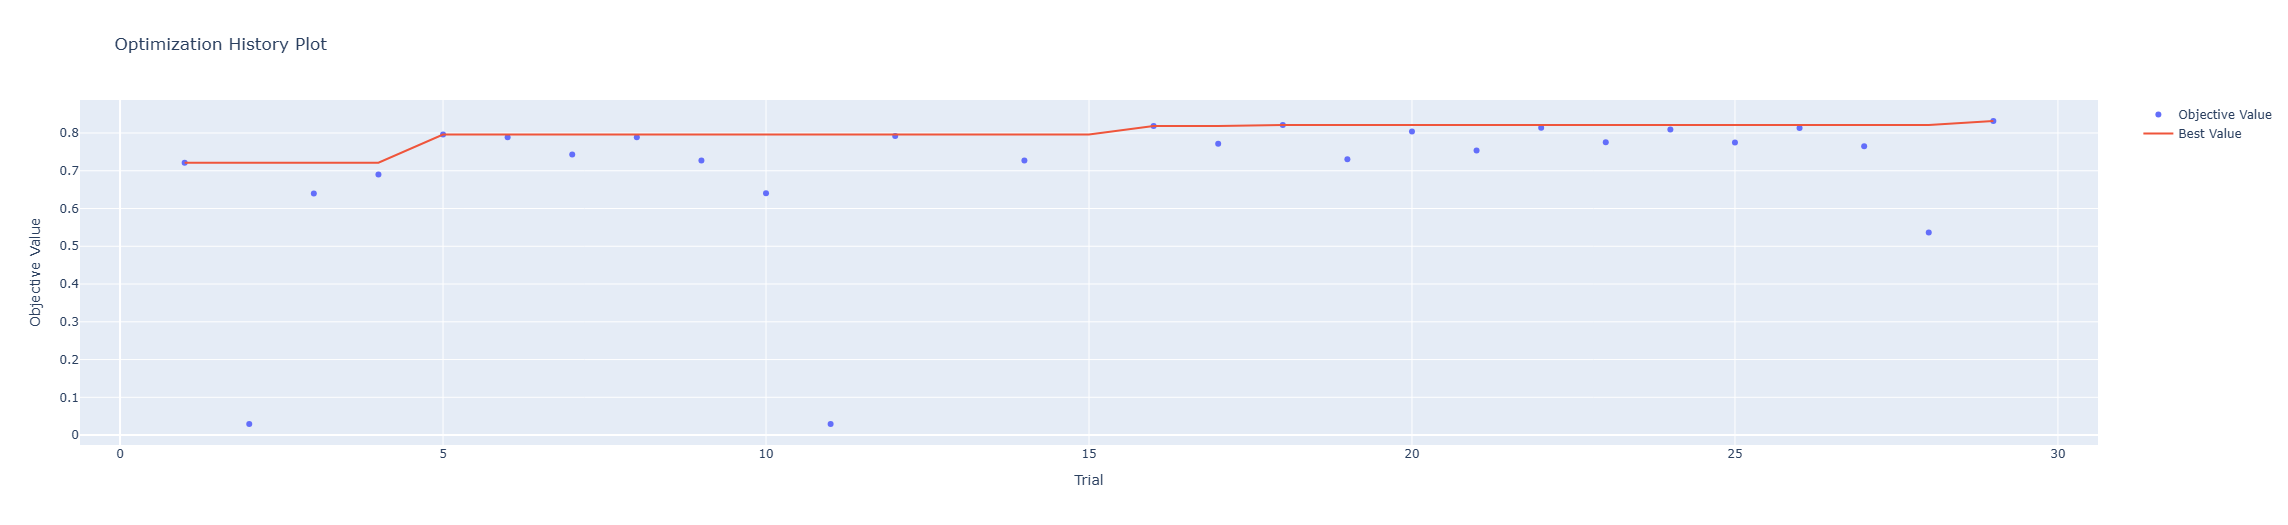

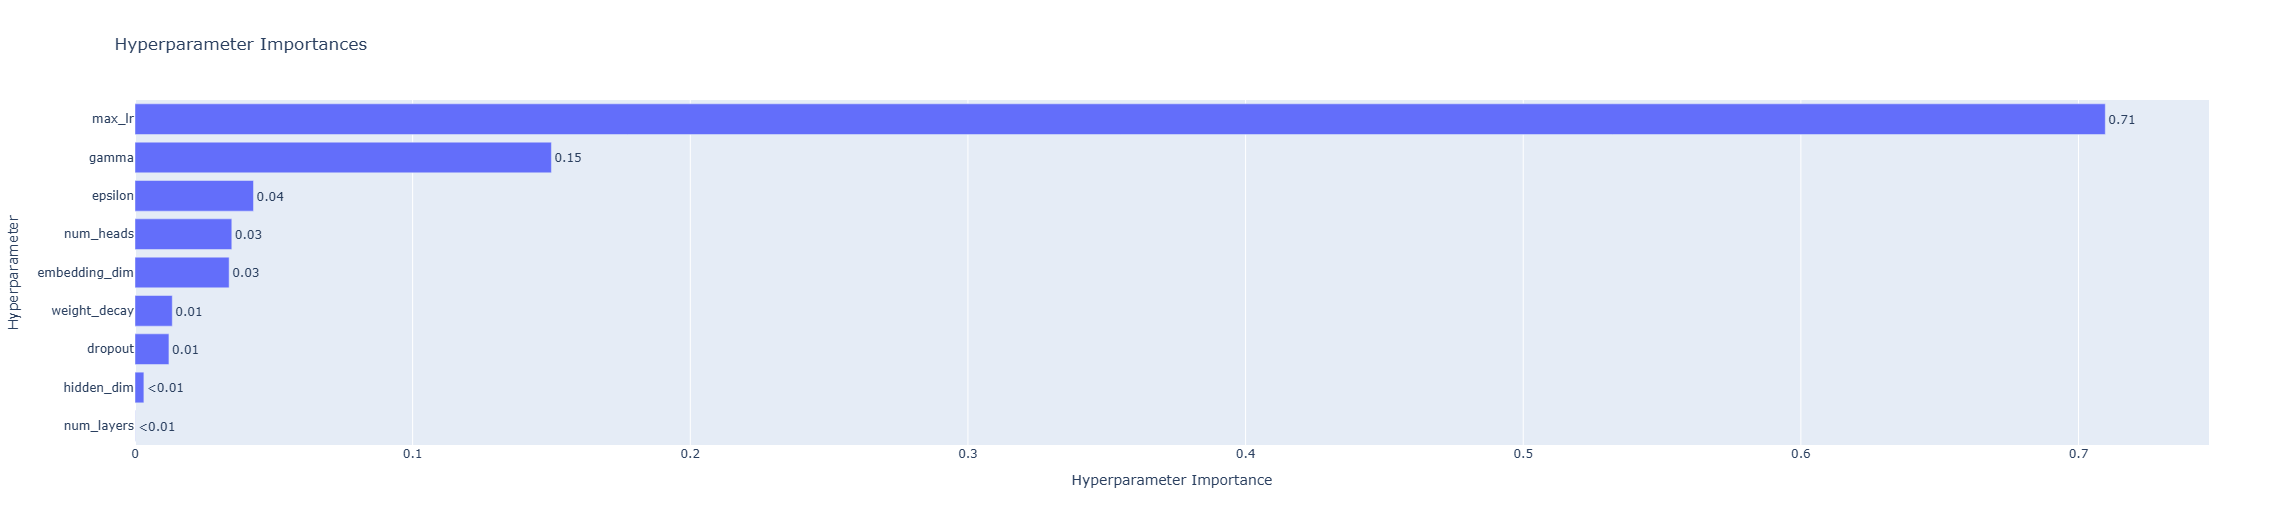

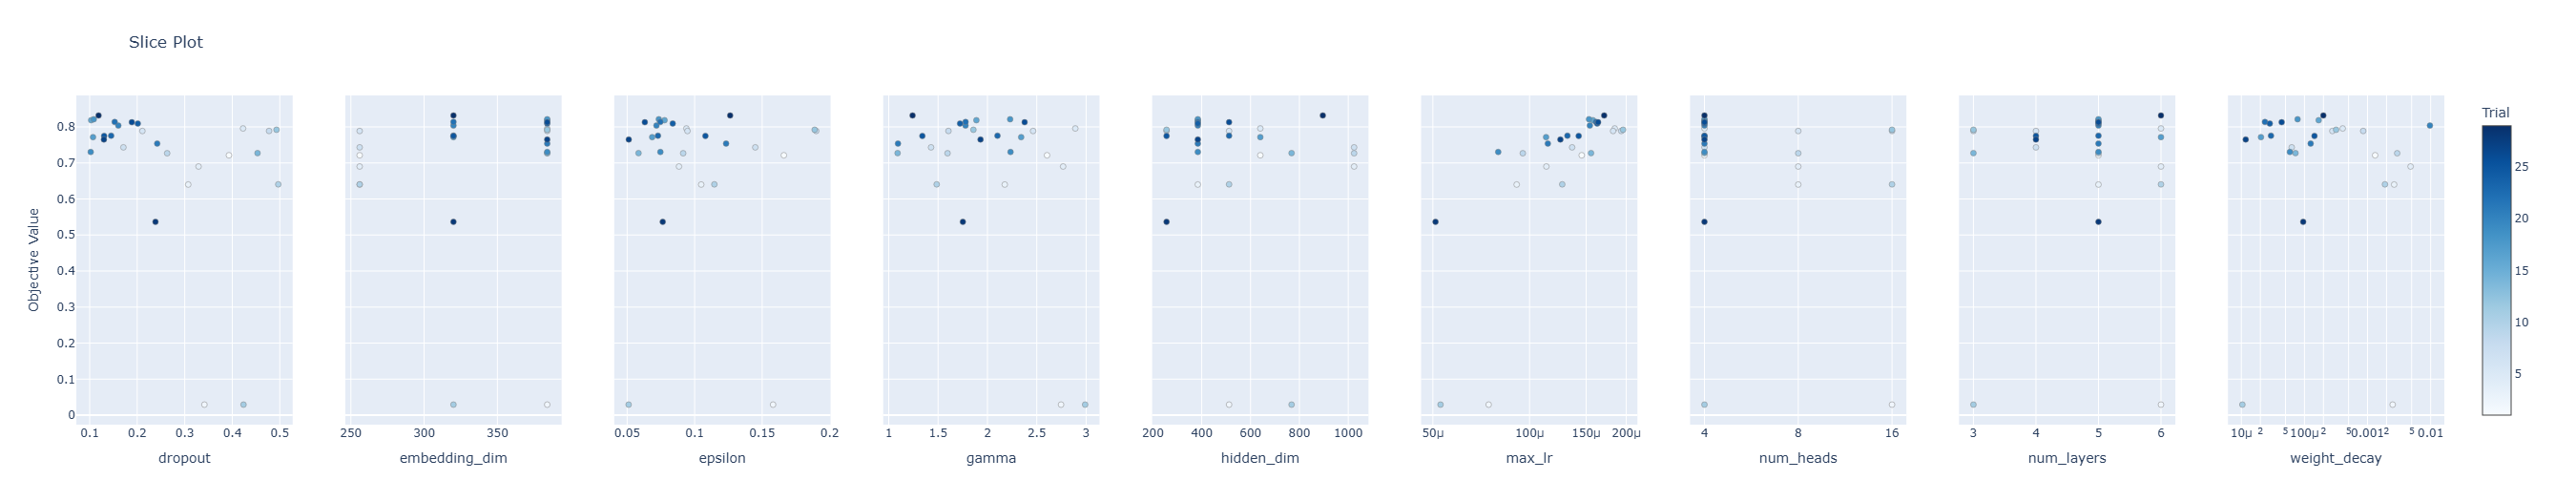

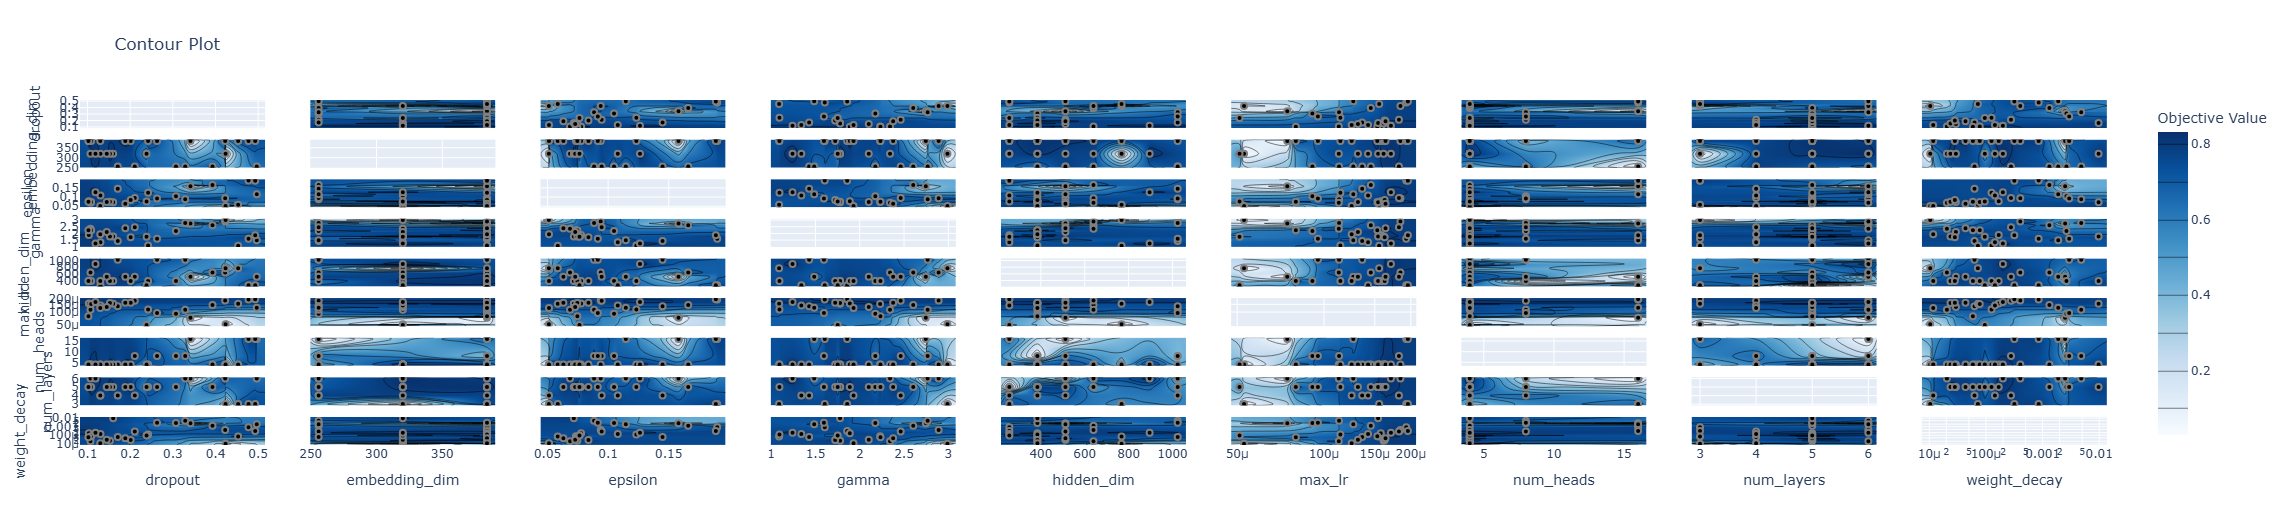

In [1]:
from IPython.display import Image, display

image_files = [
    'Plot1.png',
    'Plot2.png',
    'Plot3.png',
    'Plot4.png',
]
for img_file in image_files:
    display(Image(filename=img_file))


In [ ]:
print(study.best_params)

{'max_lr': 0.00017068444687317103, 'dropout': 0.11875039046077562, 'gamma': 1.2414987570104448, 'epsilon': 0.12628882007002423, 'num_layers': 6, 'embedding_dim': 320, 'hidden_dim': 896, 'weight_decay': 0.00019925151843235085, 'num_heads': 4}


## Final model
The optimized BERT-style model was trained with the best hyperparameters identified by Optuna for 5000 steps with a 500-step warmup period, using a batch size of 512

In [ ]:
# Train final model with best parameters
best_params = study.best_params
model = BERTModel(
    vocab_size=len(vocab),
    embedding_dim=best_params['embedding_dim'],
    num_layers=best_params['num_layers'],
    num_heads=best_params['num_heads'],
    hidden_dim=best_params['hidden_dim'],
    num_classes=num_classes,
    dropout=best_params['dropout']
)
model = torch.compile(model)
train_model(
    model=model,
    train_dataset=full_dataset,
    num_steps=5000,
    accumulation_steps=1,
    batch_size=512,
    max_lr=best_params['max_lr'],
    min_lr=1e-7,
    warmup_steps=500,
    max_steps=5000,
    device='cuda',
    stage_name="Final_Training",
    gamma=best_params['gamma'],
    epsilon=best_params['epsilon'],
    weight_decay=best_params['weight_decay'],
    patience=500
)

Streaming output truncated to the last 5000 lines.
Step 2/5000, Loss: 0.0168, Acc: 0.0068, Seq/s: 2040.32, LR: 0.000001, Norm: 812.8842, dt: 250.94ms
Step 3/5000, Loss: 0.0143, Acc: 0.0091, Seq/s: 2042.37, LR: 0.000001, Norm: 525.2390, dt: 250.69ms
Step 4/5000, Loss: 0.0136, Acc: 0.0083, Seq/s: 2043.51, LR: 0.000001, Norm: 524.1666, dt: 250.55ms
Step 5/5000, Loss: 0.0164, Acc: 0.0090, Seq/s: 2045.05, LR: 0.000002, Norm: 599.5116, dt: 250.36ms
Step 6/5000, Loss: 0.0168, Acc: 0.0078, Seq/s: 2042.12, LR: 0.000002, Norm: 849.1350, dt: 250.72ms
Step 7/5000, Loss: 0.0145, Acc: 0.0075, Seq/s: 2042.32, LR: 0.000002, Norm: 559.9684, dt: 250.69ms
Step 8/5000, Loss: 0.0135, Acc: 0.0076, Seq/s: 2040.67, LR: 0.000003, Norm: 562.9296, dt: 250.90ms
Step 9/5000, Loss: 0.0156, Acc: 0.0076, Seq/s: 2039.86, LR: 0.000003, Norm: 579.7996, dt: 251.00ms
Step 10/5000, Loss: 0.0134, Acc: 0.0078, Seq/s: 2035.03, LR: 0.000003, Norm: 495.5079, dt: 251.59ms
Step 11/5000, Loss: 0.0161, Acc: 0.0082, Seq/s: 2042.30, 

0.9147968598504989

## Evaluating the results - overall accuracy and per class performance

Test Accuracy: 0.9888


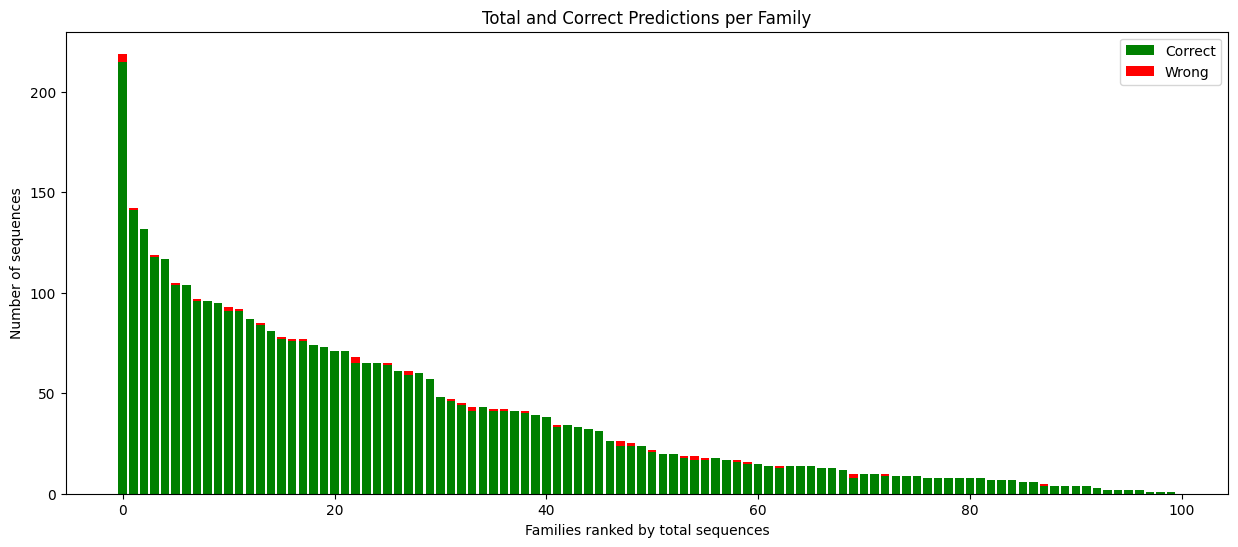

In [24]:
def evaluate_model(model, test_dataset, batch_size, device, num_classes):
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    total_correct = 0
    total_samples = 0
    correct_counts = torch.zeros(num_classes, dtype=torch.long)
    total_counts = torch.zeros(num_classes, dtype=torch.long)

    with torch.no_grad():
        for batch in test_loader:
            tokens = batch['tokens'].to(device)
            masks = batch['masks'].to(device)
            labels = batch['labels'].to(device)
            logits = model(tokens, masks)
            preds = torch.argmax(logits, dim=1)
            correct_mask = (preds == labels)
            total_correct += correct_mask.sum().item()
            total_samples += labels.size(0)

            # Update per-family counts
            labels_cpu = labels.cpu()
            correct_labels_cpu = labels_cpu[correct_mask.cpu()]
            total_counts_batch = torch.bincount(labels_cpu, minlength=num_classes)
            correct_counts_batch = torch.bincount(correct_labels_cpu, minlength=num_classes)
            total_counts += total_counts_batch
            correct_counts += correct_counts_batch

    accuracy = total_correct / total_samples if total_samples > 0 else 0
    wrong_counts = total_counts - correct_counts
    per_family_results = [(i, correct_counts[i].item(), wrong_counts[i].item()) for i in range(num_classes)]
    # per_family_results: List of (family_id, correct, wrong) for each family

    return accuracy, per_family_results

test_dataset = PfamDataset(truncated_test_df, is_aligned=False)
test_accuracy, per_family_results = evaluate_model(model, test_dataset, batch_size=512, device='cuda', num_classes=num_classes)
print(f"Test Accuracy: {test_accuracy:.4f}")

family_data = [{'family_id': fid, 'correct': correct, 'wrong': wrong, 'total': correct + wrong}
               for fid, correct, wrong in per_family_results]

#Sort families by total sequences in descending order
family_data_sorted = sorted(family_data, key=lambda x: x['total'], reverse=True)

#Extract sorted lists for plotting
family_ids_sorted = [item['family_id'] for item in family_data_sorted]
corrects_sorted = [item['correct'] for item in family_data_sorted]
wrongs_sorted = [item['wrong'] for item in family_data_sorted]

#Plot bar graph
fig, ax = plt.subplots(figsize=(15, 6))  # Adjust size for 100 families
x = range(len(family_ids_sorted))

# Plot correct predictions
ax.bar(x, corrects_sorted, color='green', label='Correct')
# Plot wrong predictions
ax.bar(x, wrongs_sorted, bottom=corrects_sorted, color='red', label='Wrong')

ax.set_xlabel('Families ranked by total sequences')
ax.set_ylabel('Number of sequences')
ax.set_title('Total and Correct Predictions per Family')
ax.legend()



In [25]:
def display_families_table(per_family_results):
    table_data = []
    for family_id, correct, wrong in per_family_results:
        total_members = correct + wrong
        table_data.append({
            'Family ID': family_id,
            'Total Members': total_members,
            'Correct': correct,
            'Wrong': wrong
        })
    # Sort families by total members in descending order
    table_data_sorted = sorted(table_data, key=lambda x: x['Total Members'], reverse=True)

    df = pd.DataFrame(table_data_sorted)
    print(f"Displaying classification of {len(df)} families")
    print(df.to_string(index=False))

display_families_table(per_family_results)

Displaying classification of 100 families
 Family ID  Total Members  Correct  Wrong
        84            219      215      4
        31            142      141      1
        24            132      132      0
        19            119      118      1
        17            117      117      0
        92            105      104      1
        36            104      104      0
        16             97       96      1
        14             96       96      0
        27             95       95      0
        22             93       91      2
        58             92       91      1
        49             87       87      0
         1             85       84      1
         8             81       81      0
         3             78       77      1
         0             77       76      1
        85             77       76      1
        15             74       74      0
        10             73       73      0
        37             71       71      0
        63             71       71

## Results
Classification performance across the 100 families was highly consistent, with most families exhibiting zero misclassifications.  Families with larger memberships showed near-perfect results, demonstrating the model’s strength on well-represented classes. The model performed very well even for families with very few training examples, highlight the model’s ability to generalise effectively in few-shot learning scenarios, likely due to the focal loss and class weights prioritising rare classes. A few families, such as Family ID 86 (19 members, 17 correct) and Family ID 52 (10 members, 8 correct), showed slightly higher error rates, possibly indicating sequences with ambiguous features. These results underscore the model’s robustness across both large and small families in the truncated dataset, suggesting strong potential for scaling to a bigger data set with many more families, given resouces.  

To prove the the advantages of this architecture we can use a baseline BERT-style model with standard cross-entropy loss and incrementally adding focal loss, class weighting and label smoothing in an ablation study style.  The results, particularly per family accuracy and F1 score for smaller families, will tell us the effectiveness of our model.  To assess whether our model is learning the correct motif and characteristic unique to each family we can generate synthetic sequences using family-specific profile HMMs or consensus sequences, ensuring conserved residues and gaps are maintained, and test our model on these sequences.

## Future Improvements

With additional computational resources and the goal of building a comprehensive classifier for the full Pfam dataset, several enhancements could be pursued. Increasing the model size—by adding more transformer layers, attention heads, increasing context length or expanding the embedding and hidden dimensions—could improve the model’s capacity to capture intricate patterns in more protein families.  A more thorough hyperparameter optimization study could also be conducted. This would involve expanding the search space to include additional parameters, such as gradient accumulation steps (currently fixed at 1) or batch size variations. Increasing the number of Optuna trials (currently 30) and testing more diverse configurations could uncover superior hyperparameter sets. An essential addition would be a validation step during tuning. Unlike the current approach, which relies solely on training accuracy, evaluating models on a separate validation set would better assess generalization to unseen data, reducing overfitting and improving the reliability of the hyperparameter selection process.

Another direction that could be taken is to fine-tune a pre-trained model like ProtBERT, which has been pre-trained on vast protein sequence datasets and encodes extensive amino acid sequencing knowledge. Fine-tuning ProtBERT on the Pfam dataset could accelerate convergence and boost performance compared to training from scratch, leveraging transfer learning to reduce resource constraints. A comparative analysis between the fine-tuned ProtBERT and the current model would clarify the advantages of this approach for protein family classification.